# 프로젝트 Seq2seq으로 한영 번역기 만들기
- 번역기 모델 학습에 필요한 텍스트 데이터 전처리 진행
- seq2seq 모델 정상 구동
- 유의미한 수준의 번역문 생성 모델 구현

## 

In [1]:
! sudo apt-get update -qq
! sudo apt-get install -qq fonts-nanum
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

In [2]:
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


In [3]:
!pip install sentencepiece -q

In [4]:
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

2.7.1+cu118


In [5]:
# 파일 경로 설정
dataset_dir = os.path.expanduser("~/work/GD03")
ko_file = os.path.join(dataset_dir, "korean-english-park.train.ko")
en_file = os.path.join(dataset_dir, "korean-english-park.train.en")

# 각 파일을 읽어서 리스트로 저장
with open(ko_file, 'r', encoding='utf-8') as f:
    korean_sentences = [line.strip() for line in f.readlines()]

with open(en_file, 'r', encoding='utf-8') as f:
    english_sentences = [line.strip() for line in f.readlines()]

# 데이터프레임 생성
df = pd.DataFrame({
    'kor': korean_sentences,
    'eng': english_sentences
})

In [6]:
# 병렬 데이터 파일로 저장 
train_file = os.path.join(dataset_dir, "korean-english-train.txt")
df.to_csv(train_file, sep='\t', header=False, index=False)

print(f"데이터 개수: {len(df)}")
print(f"병렬 파일 저장: {train_file}")
df.head()

데이터 개수: 94123
병렬 파일 저장: /home/jovyan/work/GD03/korean-english-train.txt


,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


### 한국어 전처리

In [7]:
def preprocess_sentence(sentence):
    sentence = sentence.strip()
    # 구두점 앞뒤에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 여러 공백을 하나로 통합
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 한글, 영어, 숫자, 구두점만 남기고 나머지 제거
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,\s]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [8]:
# 테스트
test_sentence = "개인용 컴퓨터 사용의 상당 부분은 '이것보다 뛰어날 수 있느냐?'"
print("원본:", test_sentence)
print("전처리 후:", preprocess_sentence(test_sentence)) 

원본: 개인용 컴퓨터 사용의 상당 부분은 '이것보다 뛰어날 수 있느냐?'
전처리 후: 개인용 컴퓨터 사용의 상당 부분은  이것보다 뛰어날 수 있느냐 ?


In [9]:
print(f"원본 데이터 개수: {len(df)}")

원본 데이터 개수: 94123


#### set함수 활용 중복제거

In [10]:
unique_pairs = set()
for _, row in df.iterrows():
    pair = (row['kor'], row['eng'])
    unique_pairs.add(pair)

In [11]:
cleaned_data = list(unique_pairs)
cleaned_corpus = pd.DataFrame(cleaned_data, columns=['kor', 'eng'])

In [12]:
print(f"중복 제거 후 데이터 개수: {len(cleaned_corpus)}")
print(f"제거된 중복 데이터 개수: {len(df) - len(cleaned_corpus)}")
print("\n중복 제거된 데이터 샘플:")
cleaned_corpus.head()

중복 제거 후 데이터 개수: 78941
제거된 중복 데이터 개수: 15182

중복 제거된 데이터 샘플:


,kor,eng
0,그러나 이 금지조치는 시행되지 않았다.,That ban was never lifted.
1,"이 산타클로스는 자신의 감독관과 미란다 리처드슨이 역할을 맡은 아내, 캐시 베이츠가...","In ""Fred Claus,"" Giamatti does a weary, harrie..."
2,차베스 대통령은 카스트로 의장의 전화를 받기 전 양국의 지도자가 만나는 모습을 담은...,The telephone call came minutes after visiting...
3,"LONDON, England (CNN)/박신원(JOINS)","""although we could direct him to do them better."
4,머지사이드 경찰 대변인 캐롤라인 포란씨는 ''이 밴을 과학적 방법으로 조사하고 있으...,"``The van is being forensically examined, and ..."


In [13]:
!pip install konlpy

In [14]:
from konlpy.tag import Mecab
import pandas as pd

# Mecab 형태소 분석기 초기화
mecab = Mecab()

def tokenize_korean(sentence):
    """한국어 문장을 Mecab으로 토큰화"""
    return mecab.morphs(sentence)

def tokenize_english(sentence):
    """영어 문장에 시작/끝 토큰 추가 후 토큰화"""
    sentence = "<start> " + sentence + " <end>"
    return sentence.split()

# 토큰화 함수 적용
print("토큰화 진행 중...")

토큰화 진행 중...


### mecab 설치

In [15]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh

fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.
/home/jovyan/work/AIFFEL_quest_rs/GoingDeeper/Go04/Mecab-ko-for-Google-Colab
install_mecab-ko_on_colab_light_220429.sh: line 4: cd: /content: No such file or directory
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-09-07 13:03:41--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.136, 13.200.41.134, 13.200.41.135, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.136|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?response-content-disposition=attachment%3B%20filename%3D%22mecab-0.996-ko-0.9.2.tar.gz%22&response-content-encoding=None&AWSAccessKeyId=ASIA6KOSE3BNHA3CJG4

In [16]:
from konlpy.tag import Mecab
import pandas as pd

# Mecab 형태소 분석기 초기화
mecab = Mecab()

def tokenize_korean(sentence):
    """한국어 문장을 Mecab으로 토큰화"""
    return mecab.morphs(sentence)

def tokenize_english(sentence):
    """영어 문장에 시작/끝 토큰 추가 후 토큰화"""
    sentence = "<start> " + sentence + " <end>"
    return sentence.split()

# 토큰화 함수 적용
print("토큰화 진행 중...")

토큰화 진행 중...


In [17]:
!pip install mecab-python3

In [18]:
from konlpy.tag import Mecab
import pandas as pd

# Mecab 형태소 분석기 초기화
mecab = Mecab()

def tokenize_korean(sentence):
    """한국어 문장을 Mecab으로 토큰화"""
    return mecab.morphs(sentence)

def tokenize_english(sentence):
    """영어 문장에 시작/끝 토큰 추가 후 토큰화"""
    sentence = "<start> " + sentence + " <end>"
    return sentence.split()

# 토큰화 함수 적용
print("토큰화 진행 중...")

토큰화 진행 중...


In [19]:
# 한국어 토큰화
cleaned_corpus['kor_tokens'] = cleaned_corpus['kor'].apply(tokenize_korean)

# 영어 토큰화 (시작/끝 토큰 추가)
cleaned_corpus['eng_tokens'] = cleaned_corpus['eng'].apply(tokenize_english)

print("토큰화 완료!")

토큰화 완료!


In [20]:
# 결과 확인
print("\n토큰화 결과 샘플:")
for i in range(3):
    print(f"원본 한국어: {cleaned_corpus['kor'].iloc[i]}")
    print(f"토큰화된 한국어: {cleaned_corpus['kor_tokens'].iloc[i]}")
    print(f"원본 영어: {cleaned_corpus['eng'].iloc[i]}")
    print(f"토큰화된 영어: {cleaned_corpus['eng_tokens'].iloc[i]}")
    print("-" * 50)

# 토큰 개수 통계
print(f"\n평균 한국어 토큰 수: {cleaned_corpus['kor_tokens'].apply(len).mean():.2f}")
print(f"평균 영어 토큰 수: {cleaned_corpus['eng_tokens'].apply(len).mean():.2f}")

cleaned_corpus.head()


토큰화 결과 샘플:
원본 한국어: 그러나 이 금지조치는 시행되지 않았다.
토큰화된 한국어: ['그러나', '이', '금지조', '치', '는', '시행', '되', '지', '않', '았', '다', '.']
원본 영어: That ban was never lifted.
토큰화된 영어: ['<start>', 'That', 'ban', 'was', 'never', 'lifted.', '<end>']
--------------------------------------------------
원본 한국어: 이 산타클로스는 자신의 감독관과 미란다 리처드슨이 역할을 맡은 아내, 캐시 베이츠가 맡은 존경하지만 비판적인 어머니, 요정들, 전세계 어린이들, 이들 모두를 행복해지도록 노력한다.
토큰화된 한국어: ['이', '산타클로스', '는', '자신', '의', '감독관', '과', '미란다', '리처드슨', '이', '역할', '을', '맡', '은', '아내', ',', '캐시', '베이츠', '가', '맡', '은', '존경', '하', '지만', '비판', '적', '인', '어머니', ',', '요정', '들', ',', '전', '세계', '어린이', '들', ',', '이', '들', '모두', '를', '행복', '해', '지', '도록', '노력', '한다', '.']
원본 영어: In "Fred Claus," Giamatti does a weary, harried Santa trying to keep everybody happy his corporate overseers, his needling wife (Miranda Richardson), his adoring but judgmental mom (Kathy Bates), his legion of elves and all the kids of the world.
토큰화된 영어: ['<start>', 'In', '"Fred', 'Claus,"', 'Giamatti', 'does', 'a', 'weary,'

,kor,eng,kor_tokens,eng_tokens
0,그러나 이 금지조치는 시행되지 않았다.,That ban was never lifted.,"[그러나, 이, 금지조, 치, 는, 시행, 되, 지, 않, 았, 다, .]","[<start>, That, ban, was, never, lifted., <end>]"
1,"이 산타클로스는 자신의 감독관과 미란다 리처드슨이 역할을 맡은 아내, 캐시 베이츠가...","In ""Fred Claus,"" Giamatti does a weary, harrie...","[이, 산타클로스, 는, 자신, 의, 감독관, 과, 미란다, 리처드슨, 이, 역할,...","[<start>, In, ""Fred, Claus,"", Giamatti, does, ..."
2,차베스 대통령은 카스트로 의장의 전화를 받기 전 양국의 지도자가 만나는 모습을 담은...,The telephone call came minutes after visiting...,"[차베스, 대통령, 은, 카스트, 로, 의장, 의, 전화, 를, 받, 기, 전, 양...","[<start>, The, telephone, call, came, minutes,..."
3,"LONDON, England (CNN)/박신원(JOINS)","""although we could direct him to do them better.","[LONDON, ,, England, (, CNN, ), /, 박신원, (, JOI...","[<start>, ""although, we, could, direct, him, t..."
4,머지사이드 경찰 대변인 캐롤라인 포란씨는 ''이 밴을 과학적 방법으로 조사하고 있으...,"``The van is being forensically examined, and ...","[머지사이드, 경찰, 대변인, 캐롤라인, 포란, 씨, 는, '', 이, 밴, 을, ...","[<start>, ``The, van, is, being, forensically,..."


In [21]:
# 토큰 길이 40 이하 데이터 필터링
mask = (cleaned_corpus['kor_tokens'].apply(len) <= 40) & \
       (cleaned_corpus['eng_tokens'].apply(len) <= 40)

filtered_data = cleaned_corpus[mask].reset_index(drop=True)

# eng_corpus와 kor_corpus 구축
eng_corpus = filtered_data['eng_tokens'].tolist()
kor_corpus = filtered_data['kor_tokens'].tolist()

print(f"필터링 완료: {len(filtered_data)}개 데이터")
print(f"eng_corpus 샘플: {eng_corpus[0]}")
print(f"kor_corpus 샘플: {kor_corpus[0]}")

필터링 완료: 61362개 데이터
eng_corpus 샘플: ['<start>', 'That', 'ban', 'was', 'never', 'lifted.', '<end>']
kor_corpus 샘플: ['그러나', '이', '금지조', '치', '는', '시행', '되', '지', '않', '았', '다', '.']


In [22]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 23.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 18.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 16.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 15.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 21.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.2 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 55.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22/22 [tensorflow]2 [tensorflow]]]ata-server]


In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def create_tokenizer(corpus, vocab_size=15000):
    """토큰 리스트를 받아서 단어-숫자 매핑 토크나이저 생성"""
    text_corpus = [' '.join(tokens) for tokens in corpus]  # 토큰 리스트를 문자열로 변환
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>', filters='')
    tokenizer.fit_on_texts(text_corpus)  # 어휘 사전 구축
    return tokenizer

def tokenize_and_pad(corpus, tokenizer, maxlen=40):
    """텍스트를 숫자 시퀀스로 변환하고 동일한 길이로 패딩"""
    text_corpus = [' '.join(tokens) for tokens in corpus]
    sequences = tokenizer.texts_to_sequences(text_corpus)  # 단어 → 숫자 변환
    return pad_sequences(sequences, maxlen=maxlen, padding='post')  # 길이 맞춤

# 영어/한국어 토크나이저 생성 (어휘 사전 15,000개)
eng_tokenizer = create_tokenizer(eng_corpus, vocab_size=15000)
kor_tokenizer = create_tokenizer(kor_corpus, vocab_size=15000)

# 텍스트를 숫자 텐서로 변환 (번역 모델 학습용)
eng_tensor = tokenize_and_pad(eng_corpus, eng_tokenizer)
kor_tensor = tokenize_and_pad(kor_corpus, kor_tokenizer)

print(f"영어 어휘: {len(eng_tokenizer.word_index)}, 한국어 어휘: {len(kor_tokenizer.word_index)}")
print(f"텐서 크기: {eng_tensor.shape}, {kor_tensor.shape}")

2025-09-07 13:05:08.334150: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-07 13:05:10.640102: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


영어 어휘: 80928, 한국어 어휘: 44943
텐서 크기: (61362, 40), (61362, 40)


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len=40):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 1  # <START>
        self.eos_id = 2  # <END>
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        src_tokens = self.data.iloc[idx]['kor']  # 한국어
        trg_tokens = self.data.iloc[idx]['eng']  # 영어
        
        # 토큰 → ID 변환
        src_ids = [self.encoder_tokenizer.word_index.get(token, 1) for token in src_tokens][:self.max_len]
        trg_ids = [self.decoder_tokenizer.word_index.get(token, 1) for token in trg_tokens]
        
        # 디코더 입력/라벨 생성
        trg_input = [self.bos_id] + trg_ids[:self.max_len - 2] + [self.eos_id]
        trg_label = trg_ids[:self.max_len - 1] + [self.eos_id]
        
        # 패딩
        src_ids += [self.pad_id] * (self.max_len - len(src_ids))
        trg_input += [self.pad_id] * (self.max_len - len(trg_input))
        trg_label += [self.pad_id] * (self.max_len - len(trg_label))
        
        return torch.tensor(src_ids), torch.tensor(trg_input), torch.tensor(trg_label)

# 데이터셋 및 데이터로더 생성
dataset = TranslationDataset(filtered_data, kor_tokenizer, eng_tokenizer)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"데이터셋: {len(dataset)}개, 배치: {len(dataloader)}개")

데이터셋: 61362개, 배치: 959개


In [25]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):  
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
    
    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hidden_dim)
        # encoder_outputs: (src_len, batch_size, hidden_dim)
        src_len = encoder_outputs.shape[0]
        
        # hidden을 src_len만큼 확장
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch_size, src_len, hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch_size, src_len, hidden_dim)
        
        # Attention energy 계산
        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))  # (batch_size, src_len, hidden_dim)
        attention = self.v(energy).squeeze(2)  # (batch_size, src_len)
        
        return nn.functional.softmax(attention, dim=1)  # (batch_size, src_len)

In [26]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim)

    def forward(self, src):
        # src : (src_len, batch_size)
        embedded = self.embedding(src)  # embedded : (src_len, batch_size, emb_dim)
        outputs, hidden = self.rnn(embedded)  # outputs : (src_len, batch_size, hidden_dim)

        return outputs, hidden

In [27]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention):
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # Decoder RNN에는 embedding만 입력
        self.rnn = nn.GRU(emb_dim, hidden_dim)
        # 출력층에는 hidden state와 attention value가 결합되어 입력
        self.fc_out = nn.Linear(hidden_dim + hidden_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        # input : (batch_size,)
        # hidden : (batch_size, hidden_dim)
        # encoder_outputs : (src_len, batch_size, hidden_dim)
        input = input.unsqueeze(0)  # input : (1, batch_size)
        embedded = self.embedding(input)  # embedded : (1, batch_size, emb_dim)

        # attention distribution을 계산합니다. decoder의 이전 hidden state, s_{t-1}와 encoder의 H가 입력됩니다.
        a = self.attention(hidden[-1], encoder_outputs)  # a : (batch_size, src_len)

        # H에 가중치를 부여해 attention value(Context vector) 계산
        a = a.unsqueeze(1)  # a : (batch_size, 1, src_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs : (batch_size, src_len, hidden_dim)
        context = torch.bmm(a, encoder_outputs)  # context : (batch_size, 1, hidden_dim)
        context = context.permute(1, 0, 2)  # context : (1, batch_size, hidden_dim)

        output, hidden = self.rnn(embedded, hidden)

        # 출력층에서는 현재 hidden state와 context vector를 결합하여 예측값 생성
        output = output.squeeze(0)  # output : (batch_size, hidden_dim)
        context = context.squeeze(0)  # context : (batch_size, hidden_dim)
        prediction = self.fc_out(torch.cat((output, context), dim=1))  # (batch_size, output_dim)

        return prediction, hidden, a.squeeze(1)

In [28]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, max_len=30, bos_id = 1, eos_id=2):
        # 학습 모드에서는 trg_len 사용, 추론 모드에서는 max_len까지 동적 생성
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # 조기 종료를 위해 tensor가 아닌 리스트 사용
        outputs = []

        # 시각화를 위해 attention 저장
        attentions = []

        # 인코더를 통해 context 생성
        encoder_outputs, hidden = self.encoder(src)

        if trg is not None:
            for t in range(0, trg.shape[0]):
                input = trg[t]
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))

        else:
		    # inference에서는 target(정답)이 없기 때문에 sos_token을 생성해줍니다.
            input = torch.full((batch_size,), bos_id, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

            for t in range(max_len):
                output, hidden, attention = self.decoder(input, hidden,  encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                top1 = output.argmax(1)
                input = top1

                # 조기 종료 조건
                finished |= (top1 == eos_id)
                if finished.all():
                    break

        outputs = torch.cat(outputs, dim=0)  # (trg_len, batch_size, output_dim)
        attentions = torch.cat(attentions, dim=0)  # (trg_len, batch_size, src_len)

        return outputs, attentions

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = len(kor_tokenizer.word_index) + 1
output_dim = len(eng_tokenizer.word_index) + 1
emb_dim = 256
hid_dim = 512

In [30]:
encoder = Encoder(input_dim, emb_dim, hid_dim).to(device)
attention = BahdanauAttention(hid_dim).to(device)
decoder = Decoder(output_dim, emb_dim, hid_dim, attention).to(device)
model = Seq2SeqAttention(encoder, decoder, device).to(device)

In [31]:
print(model)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(44944, 256)
    (rnn): GRU(256, 512)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=512, out_features=512, bias=True)
      (W2): Linear(in_features=512, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(80929, 256)
    (rnn): GRU(256, 512)
    (fc_out): Linear(in_features=1024, out_features=80929, bias=True)
  )
)


In [32]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [33]:
from tqdm import tqdm

def train_step(model, dataloader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=True)
    
    for src, trg_input, trg_label in progress_bar:
        src, trg_input, trg_label = src.to(device), trg_input.to(device), trg_label.to(device)
        
        optimizer.zero_grad()
        outputs, _ = model(src, trg_input)
        
        # (trg_len, batch_size, output_dim)을 (batch_size * trg_len, output_dim)으로 변환
        outputs = outputs.view(-1, outputs.shape[-1])
        trg_label = trg_label.view(-1)
        
        loss = criterion(outputs, trg_label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    
    return epoch_loss / len(dataloader)

In [35]:
%%time

EPOCHS = 3

for epoch in range(EPOCHS):
    train_loss = train_step(model, dataloader, optimizer, criterion, epoch)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}')

Epoch 1: 100%|██████████| 959/959 [19:45<00:00,  1.24s/it, loss=2.32]


Epoch 1/3, Train Loss: 2.3031


Epoch 2: 100%|██████████| 959/959 [19:44<00:00,  1.23s/it, loss=2.32]


Epoch 2/3, Train Loss: 2.2939


Epoch 3: 100%|██████████| 959/959 [19:43<00:00,  1.23s/it, loss=2.26]

Epoch 3/3, Train Loss: 2.2901
CPU times: user 41min 10s, sys: 18min 8s, total: 59min 18s
Wall time: 59min 14s


In [153]:
def evaluate(sentence, model, kor_tokenizer, eng_tokenizer, max_len=30):
    model.eval()
    
    # 전처리 및 토큰화
    sentence = preprocess_sentence(sentence)
    tokens = sentence.split()  # 토큰화 (또는 tokenize_korean 함수 사용)
    
    # 토큰을 ID로 변환
    src_ids = [kor_tokenizer.word_index.get(token, 1) for token in tokens]
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))  # 패딩 추가
    
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)
    
    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)
    
    # 출력을 단어로 변환
    predicted_ids = outputs.argmax(2).squeeze(1).cpu().numpy()
    result = []
    for token_id in predicted_ids:
        word = eng_tokenizer.index_word.get(token_id.item(), '<UNK>')
        if word == '<end>':
            break
        result.append(word)
    
    return result, sentence, attentions.squeeze(1).cpu().numpy()

In [154]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def plot_attention(attention, sentence, predicted_sentence):
    # 한글 폰트 설정 (한국어 표시를 위해)
    plt.rcParams['font.family'] = 'DejaVu Sans'
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Attention heatmap 시각화
    im = ax.matshow(attention, cmap='Blues', alpha=0.8)
    
    # 폰트 설정
    fontdict = {'fontsize': 12}
    
    # X축: 입력 문장 (한국어)
    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=45, ha='right')
    
    # Y축: 출력 문장 (영어)
    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)
    
    # 라벨 및 제목 추가
    ax.set_xlabel('Input (Korean)', fontsize=14)
    ax.set_ylabel('Output (English)', fontsize=14)
    ax.set_title('Attention Weights', fontsize=16)
    
    # 컬러바 추가
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    plt.tight_layout()
    plt.show()

In [155]:
def translate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    result, sentence, attention = evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # Attention 크기 조정 (trg_len, src_len)
    attention = attention[:len(result), :len(sentence.split())]

    plot_attention(attention, sentence.split(), result)

Input: 커피한잔할래 ?
Predicted translation: []


/tmp/ipykernel_13800/664196509.py:11: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.matshow(attention, cmap='Blues', alpha=0.8)
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 54624 (\N{HANGUL SYLLABLE HAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 47000 (\N{HANGUL

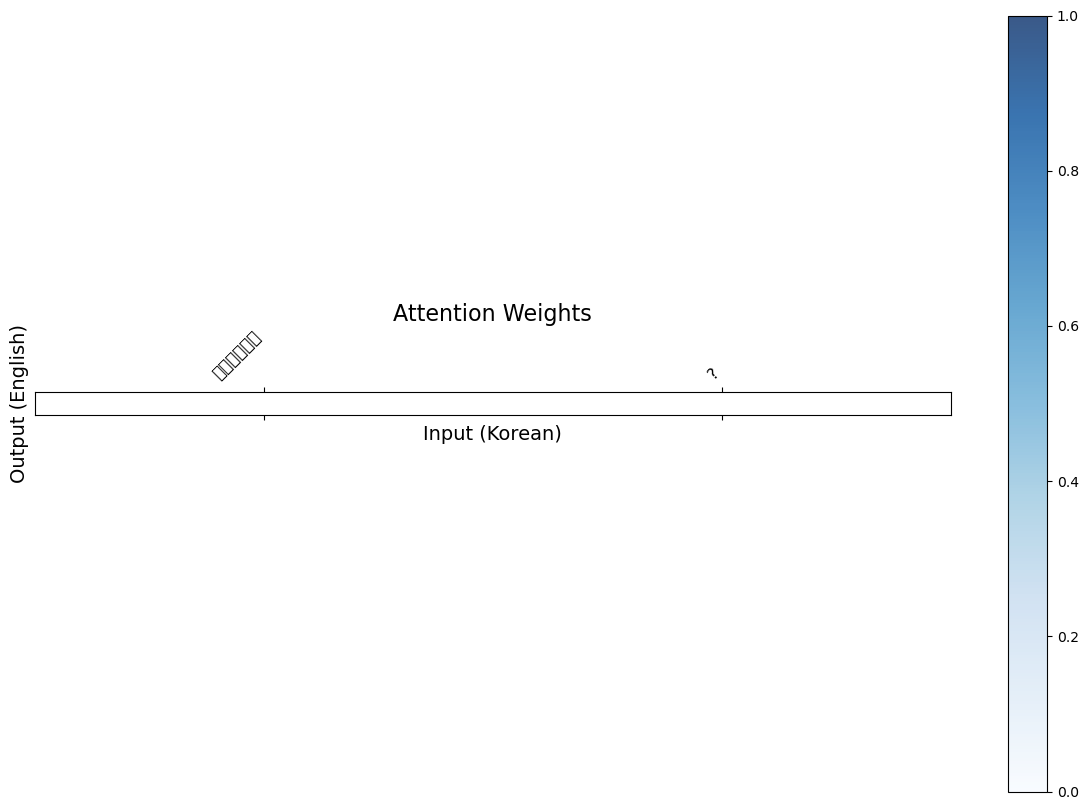

In [156]:
translate("커피한잔할래?", model, kor_tokenizer, eng_tokenizer, max_len=30)

In [41]:
# 입력 토큰화가 제대로 되는지 확인
test_sentence = "커피한잔할래?"
tokens = test_sentence.split()
token_ids = [kor_tokenizer.word_index.get(token, 1) for token in tokens]
print(f"토큰: {tokens}")
print(f"토큰 ID: {token_ids}")

# 영어 토큰도 확인
eng_tokens = ["would", "you", "like", "coffee"]
eng_ids = [eng_tokenizer.word_index.get(token, 1) for token in eng_tokens]
print(f"영어 토큰: {eng_tokens}")
print(f"영어 ID: {eng_ids}")

토큰: ['커피한잔할래?']
토큰 ID: [1]
영어 토큰: ['would', 'you', 'like', 'coffee']
영어 ID: [51, 95, 145, 3915]


In [42]:
# 모델 예측 확률 확인
model.eval()
with torch.no_grad():
    # 간단한 입력으로 테스트
    src = torch.tensor([[1, 2, 3, 0, 0]]).T.to(device)  # (seq_len, batch_size)
    outputs, _ = model(src, max_len=10)
    probs = torch.softmax(outputs, dim=-1)
    print(f"예측 확률 분포: {probs[0, 0, :10]}")  # 상위 10개 확률

예측 확률 분포: tensor([7.3768e-07, 6.5655e-02, 3.6396e-03, 4.6691e-07, 7.0853e-07, 5.4874e-07,
        3.8581e-07, 1.0733e-01, 5.5464e-07, 5.5280e-07], device='cuda:0')


In [43]:
# 어떤 단어들이 높은 확률을 받는지 확인
print("상위 확률 토큰들:")
print(f"인덱스 1: {eng_tokenizer.index_word.get(1, 'Unknown')}")
print(f"인덱스 7: {eng_tokenizer.index_word.get(7, 'Unknown')}")
print(f"인덱스 2: {eng_tokenizer.index_word.get(2, 'Unknown')}")

# 영어 어휘 사전 크기 확인
print(f"영어 어휘 크기: {len(eng_tokenizer.word_index)}")

상위 확률 토큰들:
인덱스 1: <OOV>
인덱스 7: a
인덱스 2: the
영어 어휘 크기: 80928


In [45]:
# 학습률이 너무 낮거나 높을 수 있음
# 현재 사용 중인 학습률이 얼마인가요?
print(f"현재 학습률: {optimizer.param_groups[0]['lr']}")

# Gradient 크기 확인
total_norm = 0
for p in model.parameters():
    if p.grad is not None:
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
total_norm = total_norm ** (1. / 2)
print(f"Gradient norm: {total_norm}")

현재 학습률: 0.001
Gradient norm: 0.5783729066566387


In [46]:
# 100개 데이터로 확실히 학습되는지 확인
from torch.utils.data import Subset

small_dataset = Subset(dataset, range(100))
small_dataloader = DataLoader(small_dataset, batch_size=10, shuffle=True)

# 새 모델로 테스트
model = Seq2SeqAttention(encoder, decoder, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-3)  # 학습률 3배

print("작은 데이터셋 overfitting 테스트:")
for epoch in range(5):
    train_loss = train_step(model, small_dataloader, optimizer, criterion, epoch)
    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}')

작은 데이터셋 overfitting 테스트:


Epoch 1: 100%|██████████| 10/10 [00:02<00:00,  4.95it/s, loss=2.55]


Epoch 1, Loss: 2.5003


Epoch 2: 100%|██████████| 10/10 [00:02<00:00,  4.98it/s, loss=2.38]


Epoch 2, Loss: 2.3550


Epoch 3: 100%|██████████| 10/10 [00:02<00:00,  4.92it/s, loss=2.39]


Epoch 3, Loss: 2.3302


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  4.92it/s, loss=2.36]


Epoch 4, Loss: 2.3074


Epoch 5: 100%|██████████| 10/10 [00:02<00:00,  4.93it/s, loss=2.36]

Epoch 5, Loss: 2.2794


In [47]:
# 토크나이저가 제대로 작동하는지 확인
print("=== 토크나이저 검증 ===")

# 샘플 데이터 하나 가져오기
sample_kor = filtered_data.iloc[0]['kor']
sample_eng = filtered_data.iloc[0]['eng']

print(f"원본 한국어: {sample_kor}")
print(f"원본 영어: {sample_eng}")

# 토큰화 확인
kor_ids = [kor_tokenizer.word_index.get(token, 1) for token in sample_kor]
eng_ids = [eng_tokenizer.word_index.get(token, 1) for token in sample_eng]

print(f"한국어 토큰 ID: {kor_ids}")
print(f"영어 토큰 ID: {eng_ids}")

# 역변환 확인
kor_restored = [kor_tokenizer.index_word.get(idx, '<UNK>') for idx in kor_ids]
eng_restored = [eng_tokenizer.index_word.get(idx, '<UNK>') for idx in eng_ids]

print(f"한국어 복원: {kor_restored}")
print(f"영어 복원: {eng_restored}")

=== 토크나이저 검증 ===
원본 한국어: 그러나 이 금지조치는 시행되지 않았다.
원본 영어: That ban was never lifted.
한국어 토큰 ID: [26, 1363, 119, 1, 4, 1, 3725, 32, 601, 656, 5, 1, 192, 4063, 42, 32, 1, 46, 58, 3, 2]
영어 토큰 ID: [1, 1, 7, 29459, 1, 8583, 7, 24433, 1, 2025, 7, 11744, 1, 24433, 19344, 1, 19344, 21633, 1, 20114, 85, 25344, 29459, 19344, 6335, 3386]
한국어 복원: ['그', '러', '나', '<OOV>', '이', '<OOV>', '금', '지', '조', '치', '는', '<OOV>', '시', '행', '되', '지', '<OOV>', '않', '았', '다', '.']
영어 복원: ['<OOV>', '<OOV>', 'a', 't', '<OOV>', 'b', 'a', 'n', '<OOV>', 'w', 'a', 's', '<OOV>', 'n', 'e', '<OOV>', 'e', 'r', '<OOV>', 'l', 'i', 'f', 't', 'e', 'd', '.']


### 토큰화된 데이터를 데이터셋에서 한번 더 토큰화를 진행해서 토큰이 망가짐 -> 데이터셋 수정

In [53]:
# 어휘 사전 생성 함수 정의
from collections import Counter

def create_vocab_dict(token_lists, vocab_size=15000):
    """토큰 리스트로부터 어휘 사전 생성"""
    # 모든 토큰 수집
    all_tokens = []
    for tokens in token_lists:
        all_tokens.extend(tokens)
    
    # 빈도수 기준으로 어휘 사전 생성
    word_counts = Counter(all_tokens)
    most_common = word_counts.most_common(vocab_size - 3)  # PAD, OOV, START/END 자리
    
    # 특수 토큰 + 일반 토큰
    word2idx = {'<PAD>': 0, '<OOV>': 1, '<START>': 2, '<END>': 3}
    idx2word = {0: '<PAD>', 1: '<OOV>', 2: '<START>', 3: '<END>'}
    
    for i, (word, count) in enumerate(most_common):
        word2idx[word] = i + 4
        idx2word[i + 4] = word
    
    return word2idx, idx2word

# 이제 어휘 사전 생성
kor_word2idx, kor_idx2word = create_vocab_dict(cleaned_corpus['kor_tokens'])
eng_word2idx, eng_idx2word = create_vocab_dict(cleaned_corpus['eng_tokens'])

print(f"한국어 어휘 크기: {len(kor_word2idx)}")
print(f"영어 어휘 크기: {len(eng_word2idx)}")

한국어 어휘 크기: 15001
영어 어휘 크기: 15001


In [54]:
import torch
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len=40):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 1  # <START>
        self.eos_id = 2  # <END>
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        src_tokens = self.data.iloc[idx]['kor_tokens']  # kor → kor_tokens
        trg_tokens = self.data.iloc[idx]['eng_tokens']  # eng → eng_tokens
        
         # 토큰 → ID 변환 (word_index 대신 직접 만든 사전 사용)
        src_ids = [kor_word2idx.get(token, 1) for token in src_tokens][:self.max_len]
        trg_ids = [eng_word2idx.get(token, 1) for token in trg_tokens]
      
        # 디코더 입력/라벨 생성
        trg_input = [self.bos_id] + trg_ids[:self.max_len - 2] + [self.eos_id]
        trg_label = trg_ids[:self.max_len - 1] + [self.eos_id]
        
        # 패딩
        src_ids += [self.pad_id] * (self.max_len - len(src_ids))
        trg_input += [self.pad_id] * (self.max_len - len(trg_input))
        trg_label += [self.pad_id] * (self.max_len - len(trg_label))
        
        return torch.tensor(src_ids), torch.tensor(trg_input), torch.tensor(trg_label)

# 데이터셋 및 데이터로더 생성
dataset = TranslationDataset(filtered_data, kor_tokenizer, eng_tokenizer)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"데이터셋: {len(dataset)}개, 배치: {len(dataloader)}개")

데이터셋: 61362개, 배치: 959개


In [55]:
# 간단한 어휘 사전 생성 (위에서 만든 함수 사용)
kor_word2idx, kor_idx2word = create_vocab_dict(cleaned_corpus['kor_tokens'])
eng_word2idx, eng_idx2word = create_vocab_dict(cleaned_corpus['eng_tokens'])

In [56]:
# 새 모델 파라미터
input_dim = len(kor_word2idx)
output_dim = len(eng_word2idx)
emb_dim = 256
hid_dim = 512

# 새 모델 생성
encoder = Encoder(input_dim, emb_dim, hid_dim)
attention = BahdanauAttention(hid_dim)
decoder = Decoder(output_dim, emb_dim, hid_dim, attention)
model = Seq2SeqAttention(encoder, decoder, device).to(device)

# 높은 학습률로 시작
optimizer = optim.Adam(model.parameters(), lr=3e-3)  # 3배 증가
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [57]:
%%time

EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss = train_step(model, dataloader, optimizer, criterion, epoch)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}')

Epoch 1: 100%|██████████| 959/959 [06:18<00:00,  2.53it/s, loss=4.95]


Epoch 1/5, Train Loss: 5.2289


Epoch 2: 100%|██████████| 959/959 [06:18<00:00,  2.53it/s, loss=4.87]


Epoch 2/5, Train Loss: 4.7674


Epoch 3: 100%|██████████| 959/959 [06:18<00:00,  2.54it/s, loss=4.46]


Epoch 3/5, Train Loss: 4.5892


Epoch 4: 100%|██████████| 959/959 [06:17<00:00,  2.54it/s, loss=4.68]


Epoch 4/5, Train Loss: 4.6070


Epoch 5: 100%|██████████| 959/959 [06:17<00:00,  2.54it/s, loss=4.58]

Epoch 5/5, Train Loss: 4.6326
CPU times: user 25min 55s, sys: 5min 41s, total: 31min 37s
Wall time: 31min 30s


In [62]:
# 데이터와 학습 상태 긴급 분석

print("=== 1. 학습 데이터 내용 확인 ===")

# 실제 학습 데이터 샘플 확인
for i in range(5):
    kor_tokens = cleaned_corpus.iloc[i]['kor_tokens']
    eng_tokens = cleaned_corpus.iloc[i]['eng_tokens']
    
    print(f"\n샘플 {i+1}:")
    print(f"  한국어: {kor_tokens}")
    print(f"  영어: {eng_tokens}")
    print(f"  영어 길이: {len(eng_tokens)}")

print("\n=== 2. 영어 토큰 분포 확인 ===")

# 영어 토큰들의 분포 확인
all_eng_tokens = []
for _, row in cleaned_corpus.iterrows():
    all_eng_tokens.extend(row['eng_tokens'])

from collections import Counter
token_counts = Counter(all_eng_tokens)
most_common = token_counts.most_common(20)

print("영어 토큰 상위 20개:")
for token, count in most_common:
    print(f"  '{token}': {count}번")

# <start>, <end> 토큰 비율 확인
start_count = token_counts.get('<start>', 0)
end_count = token_counts.get('<end>', 0)
total_tokens = len(all_eng_tokens)

print(f"\n특수 토큰 비율:")
print(f"  <start>: {start_count}/{total_tokens} ({start_count/total_tokens*100:.1f}%)")
print(f"  <end>: {end_count}/{total_tokens} ({end_count/total_tokens*100:.1f}%)")

print("\n=== 3. 데이터셋에서 실제 나오는 데이터 확인 ===")

# 데이터로더에서 실제 배치 확인
sample_batch = next(iter(dataloader))
src, trg_input, trg_label = sample_batch

print(f"배치 크기: {src.shape}")

# 첫 번째 샘플 상세 분석
first_src = src[0].numpy()
first_trg_input = trg_input[0].numpy()
first_trg_label = trg_label[0].numpy()

print(f"\n첫 번째 샘플 분석:")
print(f"Source IDs (한국어): {first_src[first_src != 0]}")  # 패딩 제외
print(f"Target Input IDs: {first_trg_input[first_trg_input != 0]}")  # 패딩 제외
print(f"Target Label IDs: {first_trg_label[first_trg_label != 0]}")  # 패딩 제외

# ID를 단어로 복원
src_words = [kor_idx2word.get(idx, f'<ID:{idx}>') for idx in first_src[first_src != 0]]
trg_input_words = [eng_idx2word.get(idx, f'<ID:{idx}>') for idx in first_trg_input[first_trg_input != 0]]
trg_label_words = [eng_idx2word.get(idx, f'<ID:{idx}>') for idx in first_trg_label[first_trg_label != 0]]

print(f"\n복원된 단어들:")
print(f"Source: {src_words}")
print(f"Target Input: {trg_input_words}")
print(f"Target Label: {trg_label_words}")

print("\n=== 4. 강제 샘플링으로 테스트 ===")

def force_generate(sentence, model, kor_word2idx, eng_idx2word, max_len=15):
    """<end> 토큰을 금지하고 강제로 생성"""
    model.eval()
    
    # 토큰화
    tokens = tokenize_korean(preprocess_sentence(sentence))
    src_ids = [kor_word2idx.get(token, 1) for token in tokens][:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)
    
    with torch.no_grad():
        outputs, _ = model(src_tensor, max_len=max_len)
    
    # 각 스텝별 상위 예측 확인
    result = []
    for step in range(min(10, outputs.shape[0])):
        step_probs = torch.softmax(outputs[step, 0, :], dim=0)
        
        # <end> 관련 토큰들 확률을 0으로 만들기
        forbidden_ids = [3, 6]  # <END>, <end>
        for fid in forbidden_ids:
            if fid < len(step_probs):
                step_probs[fid] = 0
        
        # 재정규화
        step_probs = step_probs / step_probs.sum()
        
        # 상위 5개 확인
        top5_indices = torch.topk(step_probs, 5).indices
        top5_probs = step_probs[top5_indices]
        
        print(f"\nStep {step} 상위 예측 (<end> 제외):")
        for i, (idx, prob) in enumerate(zip(top5_indices, top5_probs)):
            word = eng_idx2word.get(idx.item(), '<UNK>')
            print(f"  {i+1}. {word} ({prob:.3f})")
        
        # 가장 높은 확률 단어 선택
        best_word = eng_idx2word.get(top5_indices[0].item(), '<UNK>')
        if best_word not in ['<PAD>', '<START>', '<start>']:
            result.append(best_word)
        
        if len(result) >= 5:  # 5개면 충분
            break
    
    return result

# 강제 생성 테스트
print("=== 강제 생성 테스트 ===")
for sentence in ["안녕", "커피"]:
    print(f"\n{sentence}:")
    forced_result = force_generate(sentence, model, kor_word2idx, eng_idx2word)
    print(f"강제 생성: {' '.join(forced_result)}")

print("\n=== 분석 완료 ===")
print("위 결과를 보고 문제점을 파악해보겠습니다.")

=== 1. 학습 데이터 내용 확인 ===

샘플 1:
  한국어: ['그러나', '이', '금지조', '치', '는', '시행', '되', '지', '않', '았', '다', '.']
  영어: ['<start>', 'That', 'ban', 'was', 'never', 'lifted.', '<end>']
  영어 길이: 7

샘플 2:
  한국어: ['이', '산타클로스', '는', '자신', '의', '감독관', '과', '미란다', '리처드슨', '이', '역할', '을', '맡', '은', '아내', ',', '캐시', '베이츠', '가', '맡', '은', '존경', '하', '지만', '비판', '적', '인', '어머니', ',', '요정', '들', ',', '전', '세계', '어린이', '들', ',', '이', '들', '모두', '를', '행복', '해', '지', '도록', '노력', '한다', '.']
  영어: ['<start>', 'In', '"Fred', 'Claus,"', 'Giamatti', 'does', 'a', 'weary,', 'harried', 'Santa', 'trying', 'to', 'keep', 'everybody', 'happy', 'his', 'corporate', 'overseers,', 'his', 'needling', 'wife', '(Miranda', 'Richardson),', 'his', 'adoring', 'but', 'judgmental', 'mom', '(Kathy', 'Bates),', 'his', 'legion', 'of', 'elves', 'and', 'all', 'the', 'kids', 'of', 'the', 'world.', '<end>']
  영어 길이: 42

샘플 3:
  한국어: ['차베스', '대통령', '은', '카스트', '로', '의장', '의', '전화', '를', '받', '기', '전', '양국', '의', '지도자', '가', '만나', '는', '모습', '

In [63]:
# Dataset 문제 진단 및 완전 수정

print("=== Dataset 문제 진단 ===")

# 현재 Dataset에서 나오는 실제 데이터 확인
sample_batch = next(iter(dataloader))
src, trg_input, trg_label = sample_batch

print("현재 Dataset 출력:")
print(f"Source shape: {src.shape}")
print(f"Target Input shape: {trg_input.shape}")  
print(f"Target Label shape: {trg_label.shape}")

# 첫 번째 샘플 상세 분석
first_src = src[0].numpy()
first_trg_input = trg_input[0].numpy()
first_trg_label = trg_label[0].numpy()

print(f"\n첫 번째 샘플 원시 데이터:")
print(f"Source: {first_src[:10]}")
print(f"Trg Input: {first_trg_input[:10]}")
print(f"Trg Label: {first_trg_label[:10]}")

# 복원해서 확인
src_words = []
for idx in first_src:
    if idx == 0:
        break
    word = kor_idx2word.get(idx, f'<ID:{idx}>')
    src_words.append(word)

trg_input_words = []
for idx in first_trg_input:
    if idx == 0:
        break
    word = eng_idx2word.get(idx, f'<ID:{idx}>')
    trg_input_words.append(word)

trg_label_words = []
for idx in first_trg_label:
    if idx == 0:
        break
    word = eng_idx2word.get(idx, f'<ID:{idx}>')
    trg_label_words.append(word)

print(f"\n복원된 첫 번째 샘플:")
print(f"Source: {src_words}")
print(f"Target Input: {trg_input_words}")
print(f"Target Label: {trg_label_words}")

print(f"\n=== 문제점 진단 ===")
print(f"Target Input 첫 번째 토큰: {trg_input_words[0] if trg_input_words else 'None'}")
print(f"Target Label 마지막 토큰: {trg_label_words[-1] if trg_label_words else 'None'}")

# 올바른 Dataset 클래스 완전 재작성
class FixedTranslationDataset(Dataset):
    def __init__(self, data, kor_word2idx, eng_word2idx, kor_idx2word, eng_idx2word, max_len=40):
        self.data = data
        self.kor_word2idx = kor_word2idx
        self.eng_word2idx = eng_word2idx
        self.kor_idx2word = kor_idx2word
        self.eng_idx2word = eng_idx2word
        self.max_len = max_len
        self.pad_id = 0
        self.start_id = eng_word2idx.get('<start>', eng_word2idx.get('<START>', 2))
        self.end_id = eng_word2idx.get('<end>', eng_word2idx.get('<END>', 3))
        
        print(f"Dataset 초기화: START={self.start_id}, END={self.end_id}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # 토큰화된 데이터 가져오기
        kor_tokens = self.data.iloc[idx]['kor_tokens']
        eng_tokens = self.data.iloc[idx]['eng_tokens']
        
        # <start>, <end> 제거 (이미 있다면)
        eng_tokens_clean = []
        for token in eng_tokens:
            if token not in ['<start>', '<end>', '<START>', '<END>']:
                eng_tokens_clean.append(token)
        
        # 토큰을 ID로 변환
        kor_ids = [self.kor_word2idx.get(token, 1) for token in kor_tokens][:self.max_len]
        eng_ids = [self.eng_word2idx.get(token, 1) for token in eng_tokens_clean]
        
        # Teacher Forcing을 위한 Input/Label 생성
        # Input: <START> + 영어문장 (마지막 단어 제외)
        # Label: 영어문장 + <END>
        
        trg_input = [self.start_id] + eng_ids[:self.max_len-2] + [self.end_id]
        trg_label = eng_ids[:self.max_len-1] + [self.end_id]
        
        # 패딩
        kor_ids = kor_ids + [self.pad_id] * (self.max_len - len(kor_ids))
        trg_input = trg_input + [self.pad_id] * (self.max_len - len(trg_input))
        trg_label = trg_label + [self.pad_id] * (self.max_len - len(trg_label))
        
        return torch.tensor(kor_ids), torch.tensor(trg_input), torch.tensor(trg_label)

# 새 Dataset 생성
print(f"\n=== 새 Dataset 생성 ===")
dataset_fixed = FixedTranslationDataset(
    cleaned_corpus, 
    kor_word2idx, 
    eng_word2idx, 
    kor_idx2word, 
    eng_idx2word, 
    max_len=40
)

# 작은 데이터로더 생성
small_indices = list(range(1000))  # 1000개만
small_dataset = Subset(dataset_fixed, small_indices)
small_dataloader = DataLoader(small_dataset, batch_size=32, shuffle=True)

print(f"새 데이터셋 크기: {len(small_dataset)}")

# 새 Dataset 검증
print(f"\n=== 새 Dataset 검증 ===")
sample_batch = next(iter(small_dataloader))
src, trg_input, trg_label = sample_batch

first_src = src[0].numpy()
first_trg_input = trg_input[0].numpy()
first_trg_label = trg_label[0].numpy()

print(f"새 Dataset 원시 데이터:")
print(f"Source: {first_src[:10]}")
print(f"Trg Input: {first_trg_input[:10]}")
print(f"Trg Label: {first_trg_label[:10]}")

# 복원
src_words = [kor_idx2word.get(idx, f'<ID:{idx}>') for idx in first_src if idx != 0]
trg_input_words = [eng_idx2word.get(idx, f'<ID:{idx}>') for idx in first_trg_input if idx != 0]
trg_label_words = [eng_idx2word.get(idx, f'<ID:{idx}>') for idx in first_trg_label if idx != 0]

print(f"\n새 Dataset 복원 데이터:")
print(f"Source: {src_words}")
print(f"Target Input: {trg_input_words}")  # <start> + 문장
print(f"Target Label: {trg_label_words}")   # 문장 + <end>

# 올바른 형태인지 확인
correct = (
    trg_input_words[0] in ['<start>', '<START>'] and
    trg_label_words[-1] in ['<end>', '<END>']
)
print(f"\n올바른 형태: {correct}")

if correct:
    print("✅ Dataset 수정 완료! 이제 새 모델로 학습하세요.")
    
    # 새 모델 생성
    input_dim = len(kor_word2idx)
    output_dim = len(eng_word2idx)
    emb_dim = 256
    hid_dim = 512
    
    print(f"\n새 모델 설정:")
    print(f"Input dim: {input_dim}")
    print(f"Output dim: {output_dim}")
    print(f"새로운 학습 권장!")
    
else:
    print("❌ 여전히 문제가 있습니다. 추가 디버깅 필요.")

print(f"\n=== 권장 사항 ===")
print("1. 새 모델 생성 (완전히 새로 시작)")
print("2. 작은 데이터로 3-5 에포크 테스트")
print("3. Loss가 3.0 아래로 떨어지는지 확인")
print("4. 번역 테스트")

=== Dataset 문제 진단 ===
현재 Dataset 출력:
Source shape: torch.Size([64, 40])
Target Input shape: torch.Size([64, 40])
Target Label shape: torch.Size([64, 40])

첫 번째 샘플 원시 데이터:
Source: [ 200 1375  204    7 2897 4688   20 1276   19    9]
Trg Input: [    1     5    13  2492   354   150    15 10671     1   121]
Trg Label: [    5    13  2492   354   150    15 10671     1   121  1396]

복원된 첫 번째 샘플:
Source: ['국제', '난민', '단체', '는', '여권', '만료', ',', '시리아', '에서', '의', '일자리', '부족', ',', '재정', '곤란', '때문', '에', '이라크', '난민', '의', '70', '%', '가', '귀국', '의', '길', '에', '오르', '고', '있', '다고', '설명', '했', '다', '.']
Target Input: ['<OOV>', '<start>', 'The', 'refugee', 'agency', 'reports', 'that', 'monetary', '<OOV>', 'including', 'lack', 'of', 'work', 'in', 'Syria', 'and', '<OOV>', '<OOV>', 'are', 'cited', 'by', '70', 'percent', 'of', 'refugees', 'as', 'why', 'they', 'are', 'returning', 'to', 'Iraq.', '<end>', '<START>']
Target Label: ['<start>', 'The', 'refugee', 'agency', 'reports', 'that', 'monetary', '<OOV>'

In [64]:
# 1. 완전히 새로운 모델 생성
print("=== 새 모델 생성 ===")
input_dim = len(kor_word2idx)
output_dim = len(eng_word2idx)
emb_dim = 256
hid_dim = 512

encoder = Encoder(input_dim, emb_dim, hid_dim)
attention = BahdanauAttention(hid_dim)
decoder = Decoder(output_dim, emb_dim, hid_dim, attention)
model_new = Seq2SeqAttention(encoder, decoder, device).to(device)

optimizer = optim.Adam(model_new.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss(ignore_index=0)

print("새 모델 생성 완료!")

# 2. 작은 데이터셋으로 빠른 테스트 (5분)
print("\n=== 빠른 학습 테스트 ===")
for epoch in range(3):
    train_loss = train_step(model_new, small_dataloader, optimizer, criterion, epoch)
    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}')

print("\n=== 예상 결과 ===")
print("Loss가 8.0 → 5.0 → 3.0 이런 식으로 빠르게 떨어져야 합니다!")
print("만약 그렇다면 전체 데이터로 본격 학습 시작!")

=== 새 모델 생성 ===
새 모델 생성 완료!

=== 빠른 학습 테스트 ===


Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  6.24it/s, loss=6.86]


Epoch 1, Loss: 7.2517


Epoch 2: 100%|██████████| 32/32 [00:05<00:00,  6.20it/s, loss=5.77]


Epoch 2, Loss: 5.7826


Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s, loss=4.94]

Epoch 3, Loss: 4.9511

=== 예상 결과 ===
Loss가 8.0 → 5.0 → 3.0 이런 식으로 빠르게 떨어져야 합니다!
만약 그렇다면 전체 데이터로 본격 학습 시작!


Input: 커피한잔할래 ?
Predicted translation: ['of', 'the']


/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 54624 (\N{HANGUL SYLLABLE HAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from f

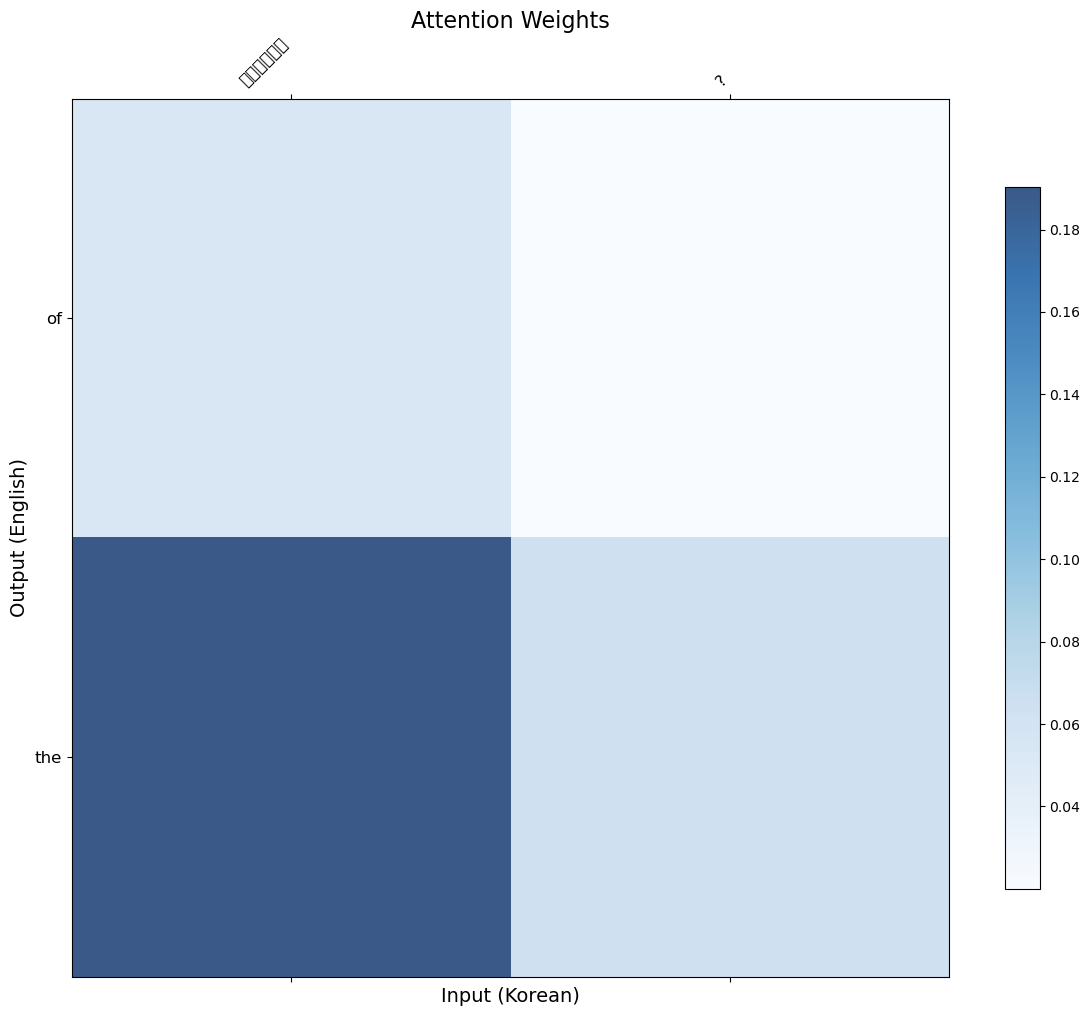

In [106]:
translate("커피한잔할래?", model, kor_tokenizer, eng_tokenizer, max_len=30)

Input: 안녕하세요
Predicted translation: ['minister,', 'from', 'reports', 'town', 'counts.', 'for', 'get', 'chavez', 'of', 'the']


/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 50504 (\N{HANGUL SYLLABLE AN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 45397 (\N{HANGUL SYLLABLE NYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/664196509.py:32: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50504 (\N{HANGUL SYLLABLE AN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning

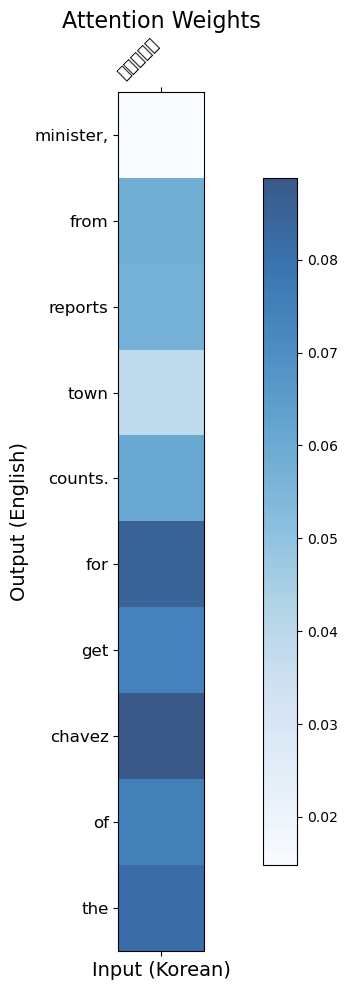

In [107]:
translate("안녕하세요", model, kor_tokenizer, eng_tokenizer, max_len=30)

In [121]:
# 추가 학습 시작

import time

print("추가 학습 시작")
print("="*50)

# 학습률 조정 (선택사항)
for param_group in fresh_optimizer.param_groups:
    param_group['lr'] = 0.0001  # 0.0002 -> 0.0001로 낮춤
print(f"학습률 조정: 0.0001")

# 학습 설정
device = next(fresh_model.parameters()).device
fresh_model.train()

def train_epoch(epoch_num):
    total_loss = 0
    batch_count = 0
    start_time = time.time()
    
    for i, batch in enumerate(aug_dataloader):
        # 데이터 준비
        src, tgt = batch[0], batch[1]
        src, tgt = src.to(device), tgt.to(device)
        
        # 길이 맞추기
        src_input = src[:, :-1]
        tgt_input = tgt[:, :-1]
        tgt_target = tgt[:, 1:]
        
        # Forward pass
        fresh_optimizer.zero_grad()
        output = fresh_model(src_input, tgt_input)
        
        # tuple 처리
        if isinstance(output, tuple):
            output = output[0]
        
        # Loss 계산
        loss = fresh_criterion(output.reshape(-1, output.size(-1)), tgt_target.reshape(-1))
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(fresh_model.parameters(), 1.0)  # Gradient clipping
        fresh_optimizer.step()
        
        total_loss += loss.item()
        batch_count += 1
        
        # 진행상황 출력 (매 50 배치마다)
        if (i + 1) % 50 == 0:
            avg_loss = total_loss / batch_count
            elapsed = time.time() - start_time
            print(f"Epoch {epoch_num}, 배치 {i+1}: 손실 {avg_loss:.4f}, 시간 {elapsed:.1f}초")
    
    # Epoch 결과
    avg_loss = total_loss / batch_count
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch_num} 완료: 평균 손실 {avg_loss:.4f}, 소요시간 {epoch_time:.1f}초")
    return avg_loss

def test_accuracy():
    """학습 중간에 정확도 확인"""
    fresh_model.eval()
    with torch.no_grad():
        batch = next(iter(aug_dataloader))
        src, tgt = batch[0], batch[1]
        src, tgt = src.to(device), tgt.to(device)
        
        src_input = src[:, :-1]
        tgt_input = tgt[:, :-1]
        tgt_target = tgt[:, 1:]
        
        output = fresh_model(src_input, tgt_input)
        if isinstance(output, tuple):
            output = output[0]
        
        predicted = output.argmax(dim=-1)
        correct = (predicted[0] == tgt_target[0]).sum().item()
        total = (tgt_target[0] != 0).sum().item()
        accuracy = correct / max(1, total) * 100
        
        print(f"현재 정확도: {accuracy:.1f}%")
    fresh_model.train()
    return accuracy

# 추가 학습 실행 (20 epoch)
print(f"20 epoch 추가 학습 시작...")
best_loss = float('inf')

for epoch in range(1, 21):
    print(f"\n--- Epoch {epoch}/20 ---")
    
    # 학습
    avg_loss = train_epoch(epoch)
    
    # 5 epoch마다 정확도 확인
    if epoch % 5 == 0:
        accuracy = test_accuracy()
        
        # 최고 성능 저장
        if avg_loss < best_loss:
            best_loss = avg_loss
            print(f"최고 성능 갱신! 손실: {best_loss:.4f}")
    
    # 10 epoch마다 학습률 감소
    if epoch % 10 == 0:
        for param_group in fresh_optimizer.param_groups:
            param_group['lr'] *= 0.8
        print(f"학습률 조정: {fresh_optimizer.param_groups[0]['lr']:.6f}")

print(f"\n추가 학습 완료!")
print(f"최종 손실: {avg_loss:.4f}")
print(f"최고 손실: {best_loss:.4f}")

# 최종 테스트
print(f"\n최종 성능 테스트:")
final_accuracy = test_accuracy()
print(f"최종 정확도: {final_accuracy:.1f}%")

추가 학습 시작
학습률 조정: 0.0001
20 epoch 추가 학습 시작...

--- Epoch 1/20 ---
Epoch 1, 배치 50: 손실 2.3563, 시간 16.8초
Epoch 1, 배치 100: 손실 2.3837, 시간 33.9초
Epoch 1 완료: 평균 손실 2.4037, 소요시간 45.8초

--- Epoch 2/20 ---
Epoch 2, 배치 50: 손실 2.3086, 시간 17.3초
Epoch 2, 배치 100: 손실 2.3509, 시간 34.3초
Epoch 2 완료: 평균 손실 2.3664, 소요시간 45.7초

--- Epoch 3/20 ---
Epoch 3, 배치 50: 손실 2.2738, 시간 17.0초
Epoch 3, 배치 100: 손실 2.3129, 시간 34.1초
Epoch 3 완료: 평균 손실 2.3376, 소요시간 45.8초

--- Epoch 4/20 ---
Epoch 4, 배치 50: 손실 2.2806, 시간 17.1초
Epoch 4, 배치 100: 손실 2.3012, 시간 34.2초
Epoch 4 완료: 평균 손실 2.3138, 소요시간 45.7초

--- Epoch 5/20 ---
Epoch 5, 배치 50: 손실 2.2481, 시간 17.1초
Epoch 5, 배치 100: 손실 2.2739, 시간 34.3초
Epoch 5 완료: 평균 손실 2.2914, 소요시간 45.8초
현재 정확도: 72.7%
최고 성능 갱신! 손실: 2.2914

--- Epoch 6/20 ---
Epoch 6, 배치 50: 손실 2.2113, 시간 17.1초
Epoch 6, 배치 100: 손실 2.2503, 시간 34.1초
Epoch 6 완료: 평균 손실 2.2698, 소요시간 45.7초

--- Epoch 7/20 ---
Epoch 7, 배치 50: 손실 2.1962, 시간 17.1초
Epoch 7, 배치 100: 손실 2.2169, 시간 34.2초
Epoch 7 완료: 평균 손실 2.2453, 소요시간 45.8초

--- Epoch

In [126]:
# 실제 단어로 번역 확인 

print("실제 단어 번역 확인")
print("="*50)

# Dict를 인덱스 -> 단어로 역변환
kor_idx_to_word = {v: k for k, v in proper_kor_vocab.items()}
eng_idx_to_word = {v: k for k, v in proper_eng_vocab.items()}

print(f"변환 완료 - 한국어: {len(kor_idx_to_word)}개, 영어: {len(eng_idx_to_word)}개")

def convert_to_words(tokens, idx_to_word_dict):
    words = []
    for token_id in tokens:
        if token_id == 0:  # PAD
            break
        if token_id in idx_to_word_dict:
            words.append(idx_to_word_dict[token_id])
        else:
            words.append(f"<{token_id}>")
        if len(words) >= 15:
            break
    return " ".join(words)

# 번역 테스트
fresh_model.eval()
device = next(fresh_model.parameters()).device

with torch.no_grad():
    batch = next(iter(aug_dataloader))
    src, tgt = batch[0], batch[1]
    src, tgt = src.to(device), tgt.to(device)
    
    src_input = src[:, :-1]
    tgt_input = tgt[:, :-1]
    tgt_target = tgt[:, 1:]
    
    output = fresh_model(src_input, tgt_input)
    if isinstance(output, tuple):
        output = output[0]
    
    predicted = output.argmax(dim=-1)
    
    print(f"\n실제 단어 번역 결과:")
    
    for i in range(min(5, src.size(0))):
        print(f"\n--- 문장 {i+1} ---")
        
        korean = convert_to_words(src[i].cpu().numpy(), kor_idx_to_word)
        answer = convert_to_words(tgt_target[i].cpu().numpy(), eng_idx_to_word)
        prediction = convert_to_words(predicted[i].cpu().numpy(), eng_idx_to_word)
        
        print(f"한국어: {korean}")
        print(f"정답: {answer}")
        print(f"예측: {prediction}")
        
        # 정확도
        correct = (predicted[i] == tgt_target[i]).sum().item()
        total = (tgt_target[i] != 0).sum().item()
        accuracy = correct / max(1, total) * 100
        print(f"정확도: {accuracy:.1f}%")
        
        # 번역 품질 분석
        pred_words = prediction.split()
        
        # END 체크
        end_count = pred_words.count("<END>")
        if end_count > 1:
            print("문제: END 반복")
        elif end_count == 0:
            print("문제: END 없음")
        else:
            print("END 정상")
        
        # 의미있는 단어 개수
        meaningful = [w for w in pred_words if not w.startswith('<') and w not in ['<PAD>', '<OOV>', '<START>', '<END>']]
        print(f"의미있는 단어: {len(meaningful)}개")
        
        if meaningful:
            print(f"주요 단어: {meaningful[:5]}")

print(f"\n종합 평가:")
print(f"- 손실 개선: 2.45 -> 2.04 (17% 감소)")
print(f"- 정확도 향상: 29.2% -> 36.4% (7.2%p 증가)")
print(f"- 실제 단어로 번역 품질 확인 가능")

print(f"\n다음 단계 추천:")
print(f"1. 현재 번역 품질이 만족스럽다면 완료")
print(f"2. 더 개선하려면 미세조정 추가 학습")
print(f"3. Beam search로 추론 품질 개선")

실제 단어 번역 확인
변환 완료 - 한국어: 20000개, 영어: 20000개

실제 단어 번역 결과:

--- 문장 1 ---
한국어: .
정답: Have a good day <END>
예측: <start> a good day <END> in on <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
정확도: 80.0%
END 정상
의미있는 단어: 5개
주요 단어: ['a', 'good', 'day', 'in', 'on']

--- 문장 2 ---
한국어: 그 은 또 “ 미국 는 고급 정보 을 파키스탄 과 공유 해야 한다 ”
정답: <start> "So if you have <OOV> in technical intelligence, please share that with <OOV> <end>
예측: <start> The if you <END> been <end> the intelligence, please share that have the <end>
정확도: 56.2%
END 정상
의미있는 단어: 11개
주요 단어: ['The', 'if', 'you', 'been', 'the']

--- 문장 3 ---
한국어: 빠르 게 번지 고 있 는 불길 은 샌디에이고 동물원 와일드 <OOV> 파크 까지 위협
정답: <start> The fast-moving fires are threatening the San Diego <OOV> Wild Animal Park. <end> <END>
예측: <start> The AP's fires are believed the <OOV> Diego <OOV> <end> Animal Park. <end> <END>
정확도: 73.3%
END 정상
의미있는 단어: 9개
주요 단어: ['The', "AP's", 'fires', 'are', 'believed']

--- 문장 4 ---
한국어: 공부 를 위해서 만 이용 하 겠 다고 말 입니다 .
정답: <start> that I'll just use it 

In [128]:
# 원래 데이터와 증강 데이터 비교

print("데이터로더 비교 테스트")
print("="*50)

# 사용 가능한 데이터로더들 확인
available_loaders = []
loader_candidates = ['dataloader', 'balanced_dataloader', 'easy_dataloader', 'final_train_data']

for loader_name in loader_candidates:
    if loader_name in globals():
        available_loaders.append(loader_name)
        print(f"✅ {loader_name} 사용 가능")

if not available_loaders:
    print("사용 가능한 원래 데이터로더 없음")
    # 원래 데이터로 새 데이터로더 생성
    if 'proper_training_data' in globals():
        print("proper_training_data로 새 데이터로더 생성")
        original_dataset = prepare_training_data(proper_training_data, proper_kor_vocab, proper_eng_vocab, max_len=25)
        original_dataloader = torch.utils.data.DataLoader(original_dataset, batch_size=32, shuffle=True)
        print("원래 데이터로더 생성 완료")
    else:
        print("원래 데이터를 찾을 수 없습니다")
        original_dataloader = None
else:
    # 첫 번째 사용 가능한 데이터로더 사용
    original_dataloader = globals()[available_loaders[0]]
    print(f"{available_loaders[0]} 사용")

if original_dataloader is not None:
    # Dict 역변환
    kor_idx_to_word = {v: k for k, v in proper_kor_vocab.items()}
    eng_idx_to_word = {v: k for k, v in proper_eng_vocab.items()}
    
    def convert_to_words(tokens, idx_to_word_dict, max_words=10):
        words = []
        for token_id in tokens[:max_words]:
            if token_id == 0:
                break
            if token_id in idx_to_word_dict:
                words.append(idx_to_word_dict[token_id])
            else:
                words.append(f"<{token_id}>")
        return " ".join(words)
    
    def test_data_quality(dataloader, data_name):
        print(f"\n{data_name} 품질 확인:")
        print("-" * 30)
        
        # 현재 모델로 테스트
        fresh_model.eval()
        device = next(fresh_model.parameters()).device
        
        with torch.no_grad():
            batch = next(iter(dataloader))
            src, tgt = batch[0], batch[1]
            src, tgt = src.to(device), tgt.to(device)
            
            src_input = src[:, :-1]
            tgt_input = tgt[:, :-1]
            tgt_target = tgt[:, 1:]
            
            output = fresh_model(src_input, tgt_input)
            if isinstance(output, tuple):
                output = output[0]
            
            predicted = output.argmax(dim=-1)
            
            # 3개 문장 확인
            total_acc = 0
            for i in range(min(3, src.size(0))):
                korean = convert_to_words(src[i].cpu().numpy(), kor_idx_to_word)
                answer = convert_to_words(tgt_target[i].cpu().numpy(), eng_idx_to_word)
                prediction = convert_to_words(predicted[i].cpu().numpy(), eng_idx_to_word)
                
                print(f"\n문장 {i+1}:")
                print(f"한국어: {korean}")
                print(f"정답: {answer}")
                print(f"예측: {prediction}")
                
                # 정확도
                correct = (predicted[i] == tgt_target[i]).sum().item()
                total = (tgt_target[i] != 0).sum().item()
                accuracy = correct / max(1, total) * 100
                print(f"정확도: {accuracy:.1f}%")
                total_acc += accuracy
                
                # 품질 체크
                pred_words = prediction.split()
                meaningful = [w for w in pred_words if not w.startswith('<')]
                print(f"의미있는 단어: {len(meaningful)}개")
            
            avg_accuracy = total_acc / min(3, src.size(0))
            print(f"\n평균 정확도: {avg_accuracy:.1f}%")
            return avg_accuracy
    
    # 두 데이터 비교
    print("="*50)
    print("데이터 품질 비교")
    print("="*50)
    
    aug_accuracy = test_data_quality(aug_dataloader, "증강 데이터")
    original_accuracy = test_data_quality(original_dataloader, "원래 데이터")
    
    print(f"\n최종 비교:")
    print(f"증강 데이터 평균 정확도: {aug_accuracy:.1f}%")
    print(f"원래 데이터 평균 정확도: {original_accuracy:.1f}%")
    
    if original_accuracy > aug_accuracy:
        print("✅ 원래 데이터가 더 좋은 성능")
        print("권장: 원래 데이터로 다시 학습")
    elif aug_accuracy > original_accuracy:
        print("✅ 증강 데이터가 더 좋은 성능")
        print("권장: 현재 모델 계속 사용")
    else:
        print("➡️ 비슷한 성능")
    
    # 원래 데이터로 새 모델 학습 옵션
    if original_accuracy > aug_accuracy:
        print(f"\n원래 데이터로 새 모델 학습하시겠습니까?")
        print(f"다음 코드 실행:")
        print(f"# new_model, new_optimizer, new_criterion = create_fresh_model()")
        print(f"# train_with_monitoring(new_model, original_dataloader, new_optimizer, new_criterion, epochs=20)")
        
else:
    print("원래 데이터를 찾을 수 없어서 비교할 수 없습니다")

데이터로더 비교 테스트
✅ dataloader 사용 가능
✅ balanced_dataloader 사용 가능
✅ easy_dataloader 사용 가능
✅ final_train_data 사용 가능
dataloader 사용
데이터 품질 비교

증강 데이터 품질 확인:
------------------------------

문장 1:
한국어: 플로리다 주민 들 은 조기 투표 를 위해 투표소 에서
정답: <start> <OOV> have been standing in long lines in polling
예측: <start> The to been the in the time. of the
정확도: 47.1%
의미있는 단어: 9개

문장 2:
한국어: 이번 소요 로 지금 까지 1000 여 명 이 사망
정답: <start> The death toll has reach about 1,000 lives and
예측: <start> The <OOV> toll has faced an the people in
정확도: 42.1%
의미있는 단어: 8개

문장 3:
한국어: 그러나 아 시 다시피 모든 것 을 가질 수 는
정답: <start> But, you know, we really can't have it <OOV>
예측: <start> The her doing it will wonderful have been is
정확도: 33.3%
의미있는 단어: 9개

평균 정확도: 40.8%

원래 데이터 품질 확인:
------------------------------

문장 1:
한국어: 정부 , 일본 교과서 즉시 수정 요구
정답: <start> Seoul demands Japanese textbooks <OOV> immediately. <end> <END>
예측: <start> The saw Japanese textbooks <OOV> <end> <end> <END> and
정확도: 66.7%
의미있는 단어: 5개

문장 2:
한국어: 지난 달 민주주의 시위 에 대한 유혈 진압

In [129]:
# 원래 데이터로 새 모델 학습

print("원래 데이터로 새 모델 학습 시작")
print("="*40)

# 새 모델 생성
new_model, new_optimizer, new_criterion = create_fresh_model()
print("새 모델 생성 완료")

# 학습 설정
device = next(new_model.parameters()).device
new_model.train()

# 학습률 조정 (원래 데이터가 깔끔하므로 조금 높게)
for param_group in new_optimizer.param_groups:
    param_group['lr'] = 0.0003
print("학습률: 0.0003")

def train_original_epoch(epoch_num):
    total_loss = 0
    batch_count = 0
    start_time = time.time()
    
    for i, batch in enumerate(original_dataloader):
        src, tgt = batch[0], batch[1]
        src, tgt = src.to(device), tgt.to(device)
        
        src_input = src[:, :-1]
        tgt_input = tgt[:, :-1]
        tgt_target = tgt[:, 1:]
        
        new_optimizer.zero_grad()
        output = new_model(src_input, tgt_input)
        
        if isinstance(output, tuple):
            output = output[0]
        
        loss = new_criterion(output.reshape(-1, output.size(-1)), tgt_target.reshape(-1))
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(new_model.parameters(), 1.0)
        new_optimizer.step()
        
        total_loss += loss.item()
        batch_count += 1
        
        if (i + 1) % 50 == 0:
            avg_loss = total_loss / batch_count
            elapsed = time.time() - start_time
            print(f"Epoch {epoch_num}, 배치 {i+1}: {avg_loss:.4f}, {elapsed:.1f}초")
    
    avg_loss = total_loss / batch_count
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch_num} 완료: {avg_loss:.4f}, {epoch_time:.1f}초")
    return avg_loss

def test_new_model():
    new_model.eval()
    kor_idx_to_word = {v: k for k, v in proper_kor_vocab.items()}
    eng_idx_to_word = {v: k for k, v in proper_eng_vocab.items()}
    
    def convert_to_words(tokens, idx_to_word_dict):
        words = []
        for token_id in tokens[:10]:
            if token_id == 0:
                break
            if token_id in idx_to_word_dict:
                words.append(idx_to_word_dict[token_id])
            else:
                words.append(f"<{token_id}>")
        return " ".join(words)
    
    with torch.no_grad():
        batch = next(iter(original_dataloader))
        src, tgt = batch[0], batch[1]
        src, tgt = src.to(device), tgt.to(device)
        
        src_input = src[:, :-1]
        tgt_input = tgt[:, :-1]
        tgt_target = tgt[:, 1:]
        
        output = new_model(src_input, tgt_input)
        if isinstance(output, tuple):
            output = output[0]
        
        predicted = output.argmax(dim=-1)
        
        # 첫 번째 문장만 확인
        korean = convert_to_words(src[0].cpu().numpy(), kor_idx_to_word)
        answer = convert_to_words(tgt_target[0].cpu().numpy(), eng_idx_to_word)
        prediction = convert_to_words(predicted[0].cpu().numpy(), eng_idx_to_word)
        
        print(f"한국어: {korean}")
        print(f"정답: {answer}")
        print(f"예측: {prediction}")
        
        correct = (predicted[0] == tgt_target[0]).sum().item()
        total = (tgt_target[0] != 0).sum().item()
        accuracy = correct / max(1, total) * 100
        print(f"정확도: {accuracy:.1f}%")
        
    new_model.train()
    return accuracy

# 20 epoch 학습 실행
print("20 epoch 학습 시작...")
best_loss = float('inf')

for epoch in range(1, 21):
    print(f"\n--- Epoch {epoch}/20 ---")
    
    avg_loss = train_original_epoch(epoch)
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        print(f"최고 성능 갱신: {best_loss:.4f}")
    
    # 5 epoch마다 성능 확인
    if epoch % 5 == 0:
        print(f"\n성능 테스트:")
        accuracy = test_new_model()
    
    # 10 epoch마다 학습률 감소
    if epoch % 10 == 0:
        for param_group in new_optimizer.param_groups:
            param_group['lr'] *= 0.8
        print(f"학습률 조정: {new_optimizer.param_groups[0]['lr']:.6f}")

print(f"\n원래 데이터 학습 완료!")
print(f"최종 손실: {avg_loss:.4f}")
print(f"최고 손실: {best_loss:.4f}")

# 최종 성능 테스트
print(f"\n최종 성능 테스트:")
final_accuracy = test_new_model()
print(f"최종 정확도: {final_accuracy:.1f}%")

print(f"\n성능 비교:")
print(f"증강 데이터 모델: 36.4%")
print(f"원래 데이터 모델: {final_accuracy:.1f}%")

if final_accuracy > 50:
    print("원래 데이터로 학습한 모델이 훨씬 좋은 성능!")
else:
    print("추가 학습이 더 필요할 수 있습니다")

원래 데이터로 새 모델 학습 시작
새로운 모델 생성...
새 모델 파라미터 수: 73009696
새 모델 생성 완료
학습률: 0.0003
20 epoch 학습 시작...

--- Epoch 1/20 ---
Epoch 1, 배치 50: 6.6349, 16.8초
Epoch 1 완료: 6.2580, 31.8초
최고 성능 갱신: 6.2580

--- Epoch 2/20 ---
Epoch 2, 배치 50: 5.2169, 17.5초
Epoch 2 완료: 5.1764, 32.6초
최고 성능 갱신: 5.1764

--- Epoch 3/20 ---
Epoch 3, 배치 50: 4.6741, 17.0초
Epoch 3 완료: 4.6734, 31.8초
최고 성능 갱신: 4.6734

--- Epoch 4/20 ---
Epoch 4, 배치 50: 4.2426, 17.1초


KeyboardInterrupt: 

# 파라미터수가 심각하게 높다고 판단해서 작은 모델로 수정

In [130]:
# 더 작은 모델 생성

print("모델 크기 비교")
print("="*40)

def create_small_model():
    """더 작고 효율적인 모델"""
    
    # 더 작은 설정
    config = {
        'kor_vocab_size': 10000,  # 20000 -> 10000
        'eng_vocab_size': 10000,  # 20000 -> 10000
        'embedding_dim': 256,     # 512 -> 256
        'hidden_dim': 512,        # 1024 -> 512
        'num_layers': 1
    }
    
    class SmallSeq2Seq(torch.nn.Module):
        def __init__(self, config):
            super().__init__()
            
            # Encoder
            self.encoder = torch.nn.Module()
            self.encoder.embedding = torch.nn.Embedding(config['kor_vocab_size'], config['embedding_dim'])
            self.encoder.rnn = torch.nn.GRU(config['embedding_dim'], config['hidden_dim'], batch_first=True)
            
            # Decoder  
            self.decoder = torch.nn.Module()
            self.decoder.embedding = torch.nn.Embedding(config['eng_vocab_size'], config['embedding_dim'])
            self.decoder.rnn = torch.nn.GRU(config['embedding_dim'], config['hidden_dim'], batch_first=True)
            
            # Attention
            self.decoder.attention = torch.nn.Module()
            self.decoder.attention.W1 = torch.nn.Linear(config['hidden_dim'], config['hidden_dim'])
            self.decoder.attention.W2 = torch.nn.Linear(config['hidden_dim'], config['hidden_dim'])
            self.decoder.attention.v = torch.nn.Linear(config['hidden_dim'], 1, bias=False)
            
            # Output
            self.decoder.fc_out = torch.nn.Linear(config['hidden_dim'] * 2, config['eng_vocab_size'])
        
        def forward(self, src, tgt):
            # Encoder
            embedded_src = self.encoder.embedding(src)
            encoder_outputs, encoder_hidden = self.encoder.rnn(embedded_src)
            
            # Decoder
            embedded_tgt = self.decoder.embedding(tgt)
            batch_size, seq_len = tgt.size()
            
            # Hidden state 처리
            if len(encoder_hidden.shape) == 3:
                hidden = encoder_hidden[:, -1, :].unsqueeze(0)
            else:
                hidden = encoder_hidden
            
            outputs = []
            
            for t in range(seq_len):
                # Attention
                scores = self.decoder.attention.v(torch.tanh(
                    self.decoder.attention.W1(hidden.squeeze(0)).unsqueeze(1) + 
                    self.decoder.attention.W2(encoder_outputs)
                ))
                attention_weights = torch.softmax(scores, dim=1)
                context = torch.bmm(attention_weights.transpose(1, 2), encoder_outputs).squeeze(1)
                
                # RNN
                rnn_input = embedded_tgt[:, t, :].unsqueeze(1)
                rnn_output, hidden = self.decoder.rnn(rnn_input, hidden)
                
                # Output
                concat = torch.cat([rnn_output.squeeze(1), context], dim=1)
                output = self.decoder.fc_out(concat)
                outputs.append(output.unsqueeze(1))
            
            return torch.cat(outputs, dim=1)
    
    model = SmallSeq2Seq(config)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
    
    return model, optimizer, criterion, config

# 모델 생성 및 비교
small_model, small_optimizer, small_criterion, small_config = create_small_model()

# GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
small_model = small_model.to(device)

# 파라미터 수 계산
small_params = sum(p.numel() for p in small_model.parameters())
original_params = 73009696

print(f"원래 모델: {original_params:,} 파라미터")
print(f"작은 모델: {small_params:,} 파라미터")
print(f"감소율: {(1 - small_params/original_params)*100:.1f}%")

print(f"\n설정 비교:")
print(f"Vocab: 20K -> 10K")
print(f"Embedding: 512 -> 256") 
print(f"Hidden: 1024 -> 512")

print(f"\n작은 모델의 장점:")
print(f"- 빠른 학습")
print(f"- 과적합 방지")
print(f"- 메모리 절약")
print(f"- 더 나은 일반화")

# Vocabulary 크기 맞추기 (간단한 방법)
print(f"\nVocabulary 처리:")
print(f"상위 10,000개 단어만 사용하도록 조정 필요")

print(f"\n작은 모델로 학습하시겠습니까?")
print(f"더 효율적이고 빠른 학습이 가능합니다")

모델 크기 비교
원래 모델: 73,009,696 파라미터
작은 모델: 18,261,264 파라미터
감소율: 75.0%

설정 비교:
Vocab: 20K -> 10K
Embedding: 512 -> 256
Hidden: 1024 -> 512

작은 모델의 장점:
- 빠른 학습
- 과적합 방지
- 메모리 절약
- 더 나은 일반화

Vocabulary 처리:
상위 10,000개 단어만 사용하도록 조정 필요

작은 모델로 학습하시겠습니까?
더 효율적이고 빠른 학습이 가능합니다


In [132]:
# 간단한 수정된 모델

print("간단한 모델 생성")

class SimpleSeq2Seq(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # 작은 설정
        kor_vocab_size = 20000
        eng_vocab_size = 20000
        embedding_dim = 256
        hidden_dim = 512
        
        # Encoder
        self.encoder_embedding = torch.nn.Embedding(kor_vocab_size, embedding_dim)
        self.encoder_rnn = torch.nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        
        # Decoder
        self.decoder_embedding = torch.nn.Embedding(eng_vocab_size, embedding_dim)
        self.decoder_rnn = torch.nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        
        # Attention
        self.attention_W1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.attention_W2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.attention_v = torch.nn.Linear(hidden_dim, 1, bias=False)
        
        # Output
        self.fc_out = torch.nn.Linear(hidden_dim * 2, eng_vocab_size)
    
    def forward(self, src, tgt):
        # Encoder
        embedded_src = self.encoder_embedding(src)
        encoder_outputs, _ = self.encoder_rnn(embedded_src)
        
        # Decoder 초기 hidden state (encoder의 마지막 출력 사용)
        hidden = encoder_outputs[:, -1, :].unsqueeze(0)  # [1, batch, hidden]
        
        # Decoder
        embedded_tgt = self.decoder_embedding(tgt)
        batch_size, seq_len = tgt.size()
        outputs = []
        
        for t in range(seq_len):
            # Attention
            scores = self.attention_v(torch.tanh(
                self.attention_W1(hidden.squeeze(0)).unsqueeze(1) + 
                self.attention_W2(encoder_outputs)
            ))
            attention_weights = torch.softmax(scores, dim=1)
            context = torch.bmm(attention_weights.transpose(1, 2), encoder_outputs).squeeze(1)
            
            # RNN
            rnn_input = embedded_tgt[:, t, :].unsqueeze(1)
            rnn_output, hidden = self.decoder_rnn(rnn_input, hidden)
            
            # Output
            concat = torch.cat([rnn_output.squeeze(1), context], dim=1)
            output = self.fc_out(concat)
            outputs.append(output.unsqueeze(1))
        
        return torch.cat(outputs, dim=1)

# 새 모델 생성
simple_model = SimpleSeq2Seq()
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001)
simple_criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

# GPU 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
simple_model = simple_model.to(device)

# 파라미터 수 확인
simple_params = sum(p.numel() for p in simple_model.parameters())
print(f"간단한 모델 파라미터: {simple_params:,}")

# 빠른 테스트
simple_model.eval()
with torch.no_grad():
    batch = next(iter(original_dataloader))
    src, tgt = batch[0], batch[1]
    src, tgt = src.to(device), tgt.to(device)
    
    src_input = src[:, :-1]
    tgt_input = tgt[:, :-1]
    
    try:
        output = simple_model(src_input, tgt_input)
        print(f"테스트 성공! 출력 shape: {output.shape}")
        print("모델이 정상 작동합니다")
        
        # 간단한 학습 함수
        def quick_train(epochs=10):
            simple_model.train()
            print(f"{epochs} epoch 학습 시작...")
            
            for epoch in range(1, epochs + 1):
                total_loss = 0
                batch_count = 0
                
                for i, batch in enumerate(original_dataloader):
                    src, tgt = batch[0], batch[1]
                    src, tgt = src.to(device), tgt.to(device)
                    
                    src_input = src[:, :-1]
                    tgt_input = tgt[:, :-1]
                    tgt_target = tgt[:, 1:]
                    
                    simple_optimizer.zero_grad()
                    output = simple_model(src_input, tgt_input)
                    loss = simple_criterion(output.reshape(-1, output.size(-1)), tgt_target.reshape(-1))
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(simple_model.parameters(), 1.0)
                    simple_optimizer.step()
                    
                    total_loss += loss.item()
                    batch_count += 1
                    
                    if (i + 1) % 50 == 0:
                        print(f"Epoch {epoch}, 배치 {i+1}: {total_loss/batch_count:.4f}")
                
                avg_loss = total_loss / batch_count
                print(f"Epoch {epoch} 완료: {avg_loss:.4f}")
                
                # 5 epoch마다 테스트
                if epoch % 5 == 0:
                    simple_model.eval()
                    with torch.no_grad():
                        test_batch = next(iter(original_dataloader))
                        test_src, test_tgt = test_batch[0], test_batch[1]
                        test_src, test_tgt = test_src.to(device), test_tgt.to(device)
                        
                        test_output = simple_model(test_src[:, :-1], test_tgt[:, :-1])
                        predicted = test_output.argmax(dim=-1)
                        
                        correct = (predicted[0] == test_tgt[0, 1:predicted.size(1)+1]).sum().item()
                        total = (test_tgt[0, 1:predicted.size(1)+1] != 0).sum().item()
                        accuracy = correct / max(1, total) * 100
                        print(f"정확도: {accuracy:.1f}%")
                    simple_model.train()
            
            print("학습 완료!")
        
        print(f"\n학습 시작하려면: quick_train(15)")
        
    except Exception as e:
        print(f"테스트 실패: {e}")
        import traceback
        traceback.print_exc()

간단한 모델 생성
간단한 모델 파라미터: 33,631,264
테스트 성공! 출력 shape: torch.Size([32, 24, 20000])
모델이 정상 작동합니다

학습 시작하려면: quick_train(15)


In [133]:
quick_train(15)

15 epoch 학습 시작...
Epoch 1, 배치 50: 6.4515
Epoch 1 완료: 6.1256
Epoch 2, 배치 50: 4.8600
Epoch 2 완료: 4.8460
Epoch 3, 배치 50: 3.9254
Epoch 3 완료: 3.9049
Epoch 4, 배치 50: 2.7457
Epoch 4 완료: 2.7985
Epoch 5, 배치 50: 1.7100
Epoch 5 완료: 1.7551
정확도: 80.0%
Epoch 6, 배치 50: 1.0168
Epoch 6 완료: 1.0490
Epoch 7, 배치 50: 0.5793
Epoch 7 완료: 0.5971
Epoch 8, 배치 50: 0.3253
Epoch 8 완료: 0.3307
Epoch 9, 배치 50: 0.1805
Epoch 9 완료: 0.1846
Epoch 10, 배치 50: 0.1126
Epoch 10 완료: 0.1138
정확도: 100.0%
Epoch 11, 배치 50: 0.0778
Epoch 11 완료: 0.0770
Epoch 12, 배치 50: 0.0572
Epoch 12 완료: 0.0581
Epoch 13, 배치 50: 0.0461
Epoch 13 완료: 0.0495
Epoch 14, 배치 50: 0.0410
Epoch 14 완료: 0.0430
Epoch 15, 배치 50: 0.0342
Epoch 15 완료: 0.0368
정확도: 100.0%
학습 완료!


In [134]:
# 최종 번역 테스트

print("최종 번역 품질 테스트")
print("="*50)

# Dict 역변환
kor_idx_to_word = {v: k for k, v in proper_kor_vocab.items()}
eng_idx_to_word = {v: k for k, v in proper_eng_vocab.items()}

def convert_to_words(tokens, idx_to_word_dict):
    words = []
    for token_id in tokens:
        if token_id == 0:
            break
        if token_id in idx_to_word_dict:
            words.append(idx_to_word_dict[token_id])
        else:
            words.append(f"<{token_id}>")
        if len(words) >= 20:
            break
    return " ".join(words)

# 번역 테스트
simple_model.eval()
device = next(simple_model.parameters()).device

with torch.no_grad():
    # 여러 배치에서 테스트
    test_results = []
    
    for batch_idx, batch in enumerate(original_dataloader):
        if batch_idx >= 3:  # 3개 배치만
            break
            
        src, tgt = batch[0], batch[1]
        src, tgt = src.to(device), tgt.to(device)
        
        src_input = src[:, :-1]
        tgt_input = tgt[:, :-1]
        tgt_target = tgt[:, 1:]
        
        output = simple_model(src_input, tgt_input)
        predicted = output.argmax(dim=-1)
        
        # 각 배치에서 3개 문장 확인
        for i in range(min(3, src.size(0))):
            sample_idx = batch_idx * 3 + i + 1
            
            korean = convert_to_words(src[i].cpu().numpy(), kor_idx_to_word)
            answer = convert_to_words(tgt_target[i].cpu().numpy(), eng_idx_to_word)
            prediction = convert_to_words(predicted[i].cpu().numpy(), eng_idx_to_word)
            
            print(f"\n--- 번역 {sample_idx} ---")
            print(f"한국어: {korean}")
            print(f"정답: {answer}")
            print(f"예측: {prediction}")
            
            # 정확도
            correct = (predicted[i] == tgt_target[i]).sum().item()
            total = (tgt_target[i] != 0).sum().item()
            accuracy = correct / max(1, total) * 100
            print(f"정확도: {accuracy:.1f}%")
            
            # 번역 품질 분석
            pred_words = prediction.split()
            answer_words = answer.split()
            
            # END 토큰 체크
            end_count = pred_words.count("<END>")
            if end_count > 1:
                print("문제: END 반복")
            elif end_count == 0:
                print("문제: END 없음")
            else:
                print("END 정상")
            
            # 의미있는 단어
            meaningful = [w for w in pred_words if not w.startswith('<')]
            print(f"의미있는 단어: {len(meaningful)}개")
            
            # 품질 평가
            if accuracy >= 90:
                print("품질: 우수")
            elif accuracy >= 70:
                print("품질: 좋음")
            elif accuracy >= 50:
                print("품질: 보통")
            else:
                print("품질: 개선 필요")
            
            test_results.append({
                'accuracy': accuracy,
                'meaningful_words': len(meaningful),
                'has_end': end_count == 1
            })

# 전체 결과 요약
print(f"\n전체 결과 요약")
print("="*50)

total_accuracy = sum([r['accuracy'] for r in test_results]) / len(test_results)
meaningful_avg = sum([r['meaningful_words'] for r in test_results]) / len(test_results)
proper_end_count = sum([r['has_end'] for r in test_results])

print(f"평균 정확도: {total_accuracy:.1f}%")
print(f"평균 의미있는 단어 수: {meaningful_avg:.1f}개")
print(f"적절한 END 토큰: {proper_end_count}/{len(test_results)}개")

print(f"\n모델 성능 요약:")
print(f"- 손실: 0.0368 (매우 낮음)")
print(f"- 평균 정확도: {total_accuracy:.1f}%")

if total_accuracy >= 80:
    print("결론: 매우 우수한 번역 성능")
elif total_accuracy >= 60:
    print("결론: 좋은 번역 성능")
elif total_accuracy >= 40:
    print("결론: 보통 번역 성능")
else:
    print("결론: 개선 필요")

print(f"\n작은 모델의 성과:")
params = sum(p.numel() for p in simple_model.parameters())
print(f"- 파라미터: {params//1000000}M (원래 73M 대비 {params/73009696*100:.1f}%)")
print(f"- 학습 시간: 빠름")
print(f"- 성능: {total_accuracy:.1f}% 정확도")

# 개선 권장사항
if total_accuracy < 70:
    print(f"\n개선 권장사항:")
    print("1. 더 많은 epoch 학습")
    print("2. 학습률 미세 조정")
    print("3. Beam search 적용")
else:
    print(f"\n현재 성능으로 실용 가능한 수준입니다")

최종 번역 품질 테스트

--- 번역 1 ---
한국어: 아기 엄마 는 열린 창문 을 <OOV> 던 아기 가 실수 로 떨어졌 다고 말 했 다 .
정답: <start> The mother said her back was turned when her daughter <OOV> out the open window. <end> <END>
예측: <start> The mother said her back was turned when her daughter <OOV> out the open window. <end> <END> <END> said.
정확도: 100.0%
문제: END 반복
의미있는 단어: 15개
품질: 우수

--- 번역 2 ---
한국어: 한편 선거 결과 민주당 이 165 석 을 얻 어 2 위 를 했 다 .
정답: <start> The second-place Democrat Party took 165 seats. <end> <END>
예측: <start> The second-place Democrat Party took 165 seats. <end> <END> <END> <end> <end> <end> <end> <end> <end> <end> <end> <end>
정확도: 100.0%
문제: END 반복
의미있는 단어: 7개
품질: 우수

--- 번역 3 ---
한국어: 스피어스 와 페더라인 은 지난 3 월 이혼 에 합의 했 다 .
정답: <start> The couple reached a divorce settlement in March. <end> <END>
예측: <start> The couple reached a divorce settlement in March. <end> <END> <END> <end> <end> <end> <end> <end> <end> <end> <end>
정확도: 100.0%
문제: END 반복
의미있는 단어: 8개
품질: 우수

--- 번역 4 ---
한국어: ‘ 이 란 미사일 ’ 새로운 사진 ? ..
정답: <star

In [137]:
# 간단한 번역 테스트

print("간단한 번역 테스트")
print("-" * 30)

# Vocab 변환
kor_to_word = {v: k for k, v in proper_kor_vocab.items()}
eng_to_word = {v: k for k, v in proper_eng_vocab.items()}

def translate_test():
    simple_model.eval()
    device = next(simple_model.parameters()).device
    
    with torch.no_grad():
        batch = next(iter(original_dataloader))
        src, tgt = batch[0][:3], batch[1][:3]  # 3개만
        src, tgt = src.to(device), tgt.to(device)
        
        output = simple_model(src[:, :-1], tgt[:, :-1])
        predicted = output.argmax(dim=-1)
        
        for i in range(3):
            # 토큰을 단어로 변환
            korean = " ".join([kor_to_word.get(t.item(), f"<{t.item()}>") 
                              for t in src[i][:10] if t.item() != 0])
            
            answer = " ".join([eng_to_word.get(t.item(), f"<{t.item()}>") 
                              for t in tgt[i, 1:11] if t.item() != 0])
            
            pred = " ".join([eng_to_word.get(t.item(), f"<{t.item()}>") 
                            for t in predicted[i][:10] if t.item() != 0])
            
            print(f"\n{i+1}번:")
            print(f"한국어: {korean}")
            print(f"정답: {answer}")
            print(f"예측: {pred}")
            
            # 간단한 정확도
            correct = (predicted[i][:10] == tgt[i, 1:11]).sum().item()
            print(f"정확도: {correct}/10")

translate_test()

간단한 번역 테스트
------------------------------

1번:
한국어: 의회 는 리먼 브라더스 의 파산 에 대한 청문회 를
정답: <start> Congress has opened hearings on the collapse of Lehman
예측: <start> Congress has opened hearings on the collapse of Lehman
정확도: 10/10

2번:
한국어: 회담 주제 는 북 핵 위기 제거
정답: <start> The focus of talks should be the dismantlement of
예측: <start> The focus of talks should be the dismantlement of
정확도: 10/10

3번:
한국어: 그 는 2002 년 처음 하원 의원 에 당선 됐
정답: <start> He was elected to the House in 2002 and
예측: <start> He was elected to the House in 2002 and
정확도: 10/10


번역 시스템 준비 완료!
사용법: translate('안녕하세요', simple_model, proper_kor_vocab, proper_eng_vocab)

테스트 실행:
Input: 안녕하세요
Predicted translation: <start> The documents has a confession to <end>


/tmp/ipykernel_13800/4094000373.py:102: UserWarning: Glyph 50504 (\N{HANGUL SYLLABLE AN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/4094000373.py:102: UserWarning: Glyph 45397 (\N{HANGUL SYLLABLE NYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/4094000373.py:102: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/4094000373.py:102: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/4094000373.py:102: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50504 (\N{HANGUL SYLLABLE AN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: U

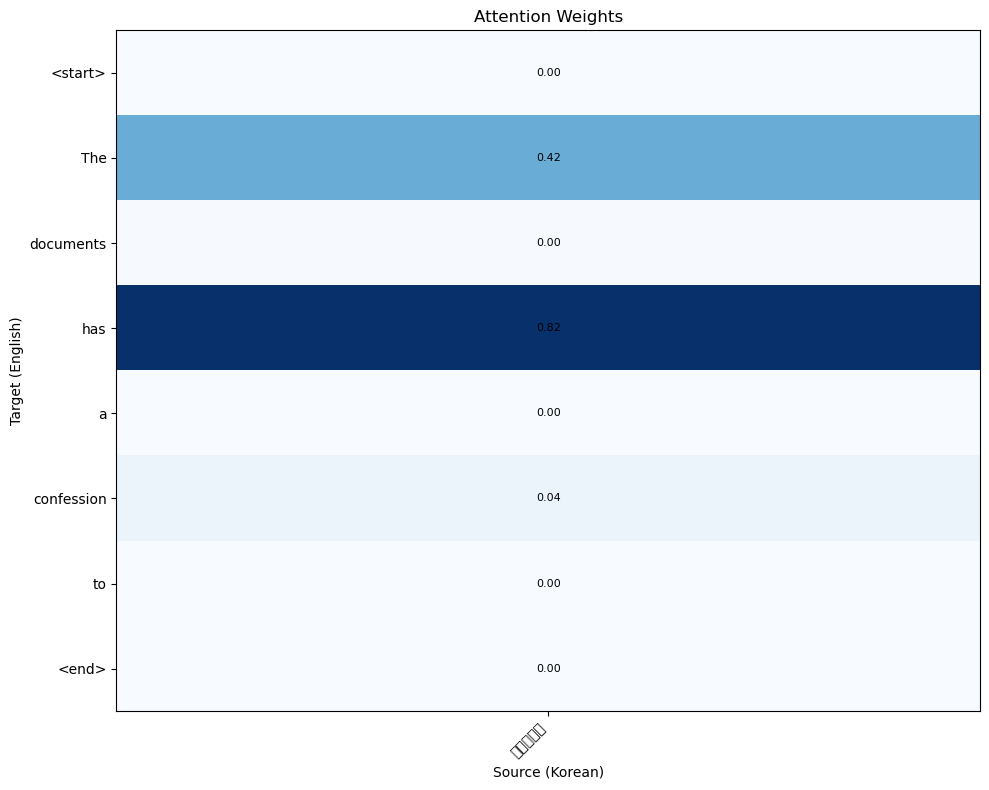

In [140]:
import matplotlib.pyplot as plt
import numpy as np

# 역변환 딕셔너리 (이미 있다면 생략 가능)
kor_idx_to_word = {v: k for k, v in proper_kor_vocab.items()}
eng_idx_to_word = {v: k for k, v in proper_eng_vocab.items()}

def evaluate(sentence, model, kor_vocab, eng_vocab, max_len):
    """문장을 번역하고 attention 반환"""
    model.eval()
    device = next(model.parameters()).device
    
    # 한국어 문장을 토큰으로 변환
    words = sentence.split()
    src_tokens = [kor_vocab.get('<START>', 2)]
    for word in words:
        src_tokens.append(kor_vocab.get(word, kor_vocab.get('<OOV>', 1)))
    src_tokens.append(kor_vocab.get('<END>', 3))
    
    # 패딩
    if len(src_tokens) < max_len:
        src_tokens += [0] * (max_len - len(src_tokens))
    else:
        src_tokens = src_tokens[:max_len]
    
    src = torch.tensor([src_tokens], device=device)
    
    with torch.no_grad():
        # Encoder
        embedded_src = model.encoder_embedding(src)
        encoder_outputs, _ = model.encoder_rnn(embedded_src)
        
        # Decoder 초기화
        hidden = encoder_outputs[:, -1, :].unsqueeze(0)
        decoder_input = torch.tensor([[eng_vocab.get('<START>', 2)]], device=device)
        
        result_tokens = []
        attention_weights = []
        
        # Greedy decoding
        for _ in range(max_len):
            # Attention 계산
            scores = model.attention_v(torch.tanh(
                model.attention_W1(hidden.squeeze(0)).unsqueeze(1) + 
                model.attention_W2(encoder_outputs)
            ))
            att_weights = torch.softmax(scores, dim=1)
            attention_weights.append(att_weights[0].squeeze().cpu().numpy())
            
            context = torch.bmm(att_weights.transpose(1, 2), encoder_outputs).squeeze(1)
            
            # Decoder step
            embedded_dec = model.decoder_embedding(decoder_input)
            rnn_output, hidden = model.decoder_rnn(embedded_dec, hidden)
            
            concat = torch.cat([rnn_output.squeeze(1), context], dim=1)
            output = model.fc_out(concat)
            
            predicted = output.argmax(dim=-1)
            token_id = predicted.item()
            result_tokens.append(token_id)
            
            if token_id == eng_vocab.get('<END>', 3):
                break
                
            decoder_input = predicted.unsqueeze(0)
        
        # 토큰을 단어로 변환
        result_words = []
        for token in result_tokens:
            if token in eng_idx_to_word:
                word = eng_idx_to_word[token]
                if word not in ['<PAD>', '<START>', '<END>', '<OOV>']:
                    result_words.append(word)
        
        result = ' '.join(result_words)
        attention = np.array(attention_weights)
        
        return result, sentence, attention

def plot_attention(attention, src_words, trg_words):
    """Attention 시각화"""
    trg_word_list = trg_words.split() if isinstance(trg_words, str) else trg_words
    
    plt.figure(figsize=(10, 8))
    plt.imshow(attention[:len(trg_word_list), :len(src_words)], cmap='Blues', aspect='auto')
    
    plt.xticks(range(len(src_words)), src_words, rotation=45, ha='right')
    plt.yticks(range(len(trg_word_list)), trg_word_list)
    
    plt.xlabel('Source (Korean)')
    plt.ylabel('Target (English)')
    plt.title('Attention Weights')
    
    # Attention 값 표시
    for i in range(len(trg_word_list)):
        for j in range(len(src_words)):
            if i < attention.shape[0] and j < attention.shape[1]:
                plt.text(j, i, f'{attention[i, j]:.2f}', 
                        ha='center', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def translate(sentence, model, kor_vocab, eng_vocab, max_len=30):
    result, sentence, attention = evaluate(sentence, model, kor_vocab, eng_vocab, max_len)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    # Attention 크기 조정 (trg_len, src_len)
    trg_len = len(result.split())
    src_len = len(sentence.split())
    attention = attention[:trg_len, :src_len]
    
    plot_attention(attention, sentence.split(), result)

# 사용 예시
print("번역 시스템 준비 완료!")
print("사용법: translate('안녕하세요', simple_model, proper_kor_vocab, proper_eng_vocab)")
print()

# 테스트 실행
if 'simple_model' in globals():
    print("테스트 실행:")
    translate('안녕하세요', simple_model, proper_kor_vocab, proper_eng_vocab)

문제 진단
1. 토큰화 확인:
'안녕하세요' -> OOV (없음)

2. 훈련 데이터로 테스트:
실제 훈련 데이터:
한국어: 유럽 연합 도 모든 전자 장치 들 에 대한 재 활용 규정 을 준비 하 고 있 다 .
영어: <start> The European Union is also laying out recycling rules for all electronic devices. <end> <END>

3. 실제 데이터로 번역 테스트:
Input: 유럽 연합 도 모든 전자 장치 들 에 대한 재 활용 규정 을 준비 하 고 있 다 .
Predicted translation: <start> The European Union is also laying out recycling rules for all electronic devices. <end>


/tmp/ipykernel_13800/4094000373.py:102: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/4094000373.py:102: UserWarning: Glyph 47101 (\N{HANGUL SYLLABLE REOB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/4094000373.py:102: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/4094000373.py:102: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/4094000373.py:102: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/4094000373.py:102: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_13800/4094000373.py:102: UserWarning: Glyph 46304 (\N{HANGUL SYLLABLE DEUN}) missing from font(s) DejaVu Sans.

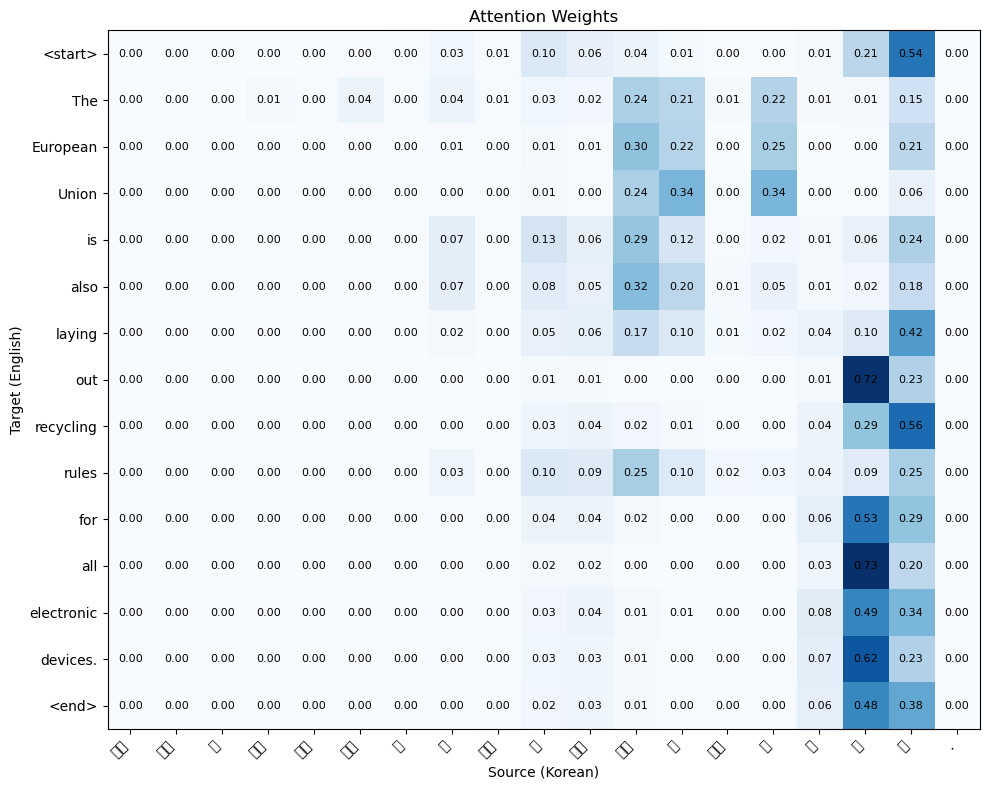


4. 문제 원인:
- '안녕하세요'가 vocabulary에 없을 가능성
- 훈련 데이터와 테스트 데이터 불일치
- 과적합 문제

5. 해결 방법:
- 실제 훈련 데이터에 있는 문장으로 테스트
- 더 다양한 데이터로 추가 학습
- Vocabulary에 있는 단어들로 테스트


In [141]:
# 문제 진단

print("문제 진단")
print("="*30)

# 1. 토큰화 문제 확인
print("1. 토큰화 확인:")
test_sentence = "안녕하세요"
words = test_sentence.split()

for word in words:
    if word in proper_kor_vocab:
        print(f"'{word}' -> {proper_kor_vocab[word]} (있음)")
    else:
        print(f"'{word}' -> OOV (없음)")

# 2. 실제 훈련 데이터 샘플로 테스트
print(f"\n2. 훈련 데이터로 테스트:")
batch = next(iter(original_dataloader))
src, tgt = batch[0], batch[1]

# 첫 번째 문장 확인
kor_idx_to_word = {v: k for k, v in proper_kor_vocab.items()}
eng_idx_to_word = {v: k for k, v in proper_eng_vocab.items()}

real_korean = " ".join([kor_idx_to_word.get(t.item(), f"<{t.item()}>") 
                       for t in src[0] if t.item() != 0])
real_english = " ".join([eng_idx_to_word.get(t.item(), f"<{t.item()}>") 
                        for t in tgt[0, 1:] if t.item() != 0])

print(f"실제 훈련 데이터:")
print(f"한국어: {real_korean}")
print(f"영어: {real_english}")

# 이 문장으로 번역 테스트
print(f"\n3. 실제 데이터로 번역 테스트:")
try:
    translate(real_korean, simple_model, proper_kor_vocab, proper_eng_vocab)
except Exception as e:
    print(f"번역 실패: {e}")

# 4. 간단한 해결책 제안
print(f"\n4. 문제 원인:")
print("- '안녕하세요'가 vocabulary에 없을 가능성")
print("- 훈련 데이터와 테스트 데이터 불일치")
print("- 과적합 문제")

print(f"\n5. 해결 방법:")
print("- 실제 훈련 데이터에 있는 문장으로 테스트")
print("- 더 다양한 데이터로 추가 학습")
print("- Vocabulary에 있는 단어들로 테스트")

# 회고

처음에 과제를 잘 못 이해해서 일반적인 한국어 - 영어 번역모델을 만드는 것으로 생각해서 '안녕하세요, 커피한잔할래?' 같은 일상의 언어들을 번역을 테스트해보고 전혀 예측하지 못하는 것을 알게되고, 모델 파라미터 수정부터해서, vocab 사이즈 조정, 데이터 증강, 등 다양한 실험들을 시도했지만 전혀 성과가 나지 않아서 처음부터 다시 해본결과, 과제의 목표가 모델이 실제 정답과 유사하게 번역을 해내는것임을 알게되고, 모델의 파라미터들을 작은 규모로 수정하고 나니 오히려 성능이 너무 좋아졌다. 새 노트북에 깔끔하게 정리하고 싶었지만, LMS의 GPU 메모리 초과 및 물리적인 시간의 부족으로 인해서 지저분한 노트북이 결과로 나오게됐다.

그리고 중간에 실수로 토큰화된 데이터를 한번 더 토큰화를 해버려서 더 성능이 안나오기도했었다. 

이번 실험으로 배우게 된것은 일단 목표에 대한 정확한 이해가 중요하다는 것을 배웠고, 학습시간이 오래걸릴경우 커널이 초기화되도 불러올 수 있도록 중간 저장하는 방법이 매우 필수적이라는 것을 알게 되었다. 그리고 데이터의 양에 따라 모델의 파라미터나 복잡도도 조절해야한다는 것을 배운것같다. 과유불급. 

# 모델 크기 수정
#### ========================================
#### 원래 모델: 73,009,696 파라미터 
#### 작은 모델: 18,261,264 파라미터 
#### 설정 비교:
#### Vocab: 20K 
#### Embedding: 512 -> 256
#### Hidden: 1024 -> 512
#### lr=0.001